In [2]:
import sys

sys.path.append(".")

import os
import pickle
import numpy as np
import pandas as pd
from utils import read_msi
from pyimzml.ImzMLWriter import ImzMLWriter
from pyimzml.ImzMLParser import ImzMLParser
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from processing import MeanSegmentation, ZScoreCorrection
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

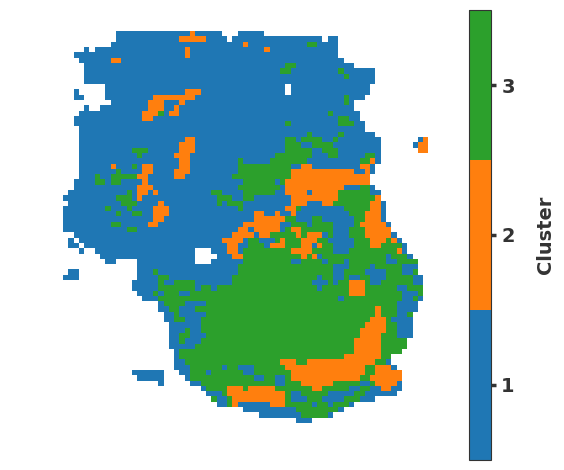

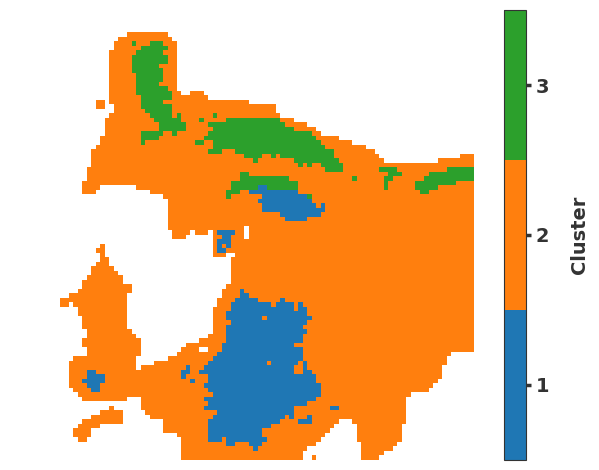

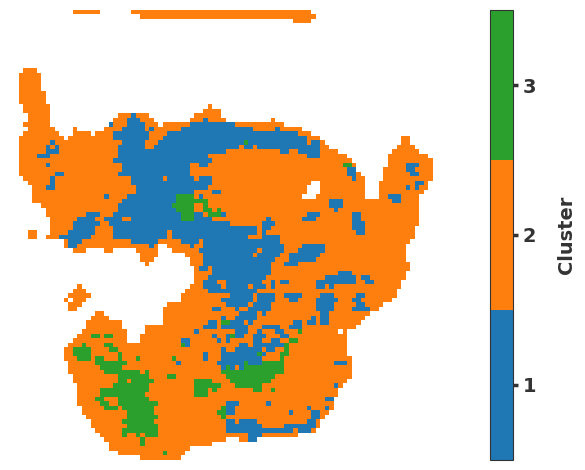

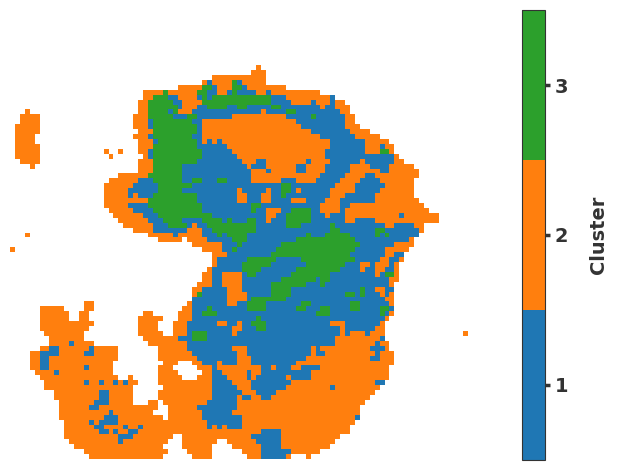

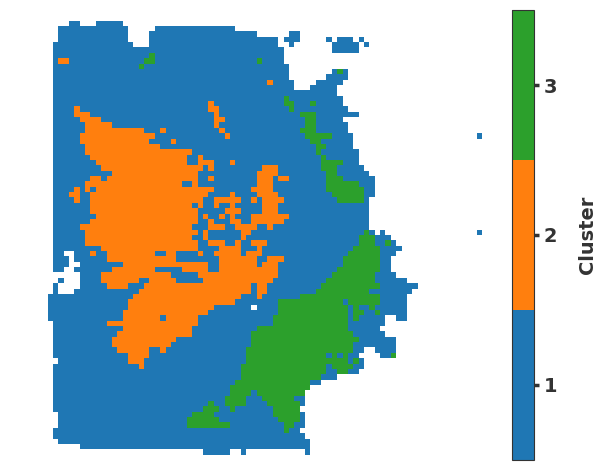

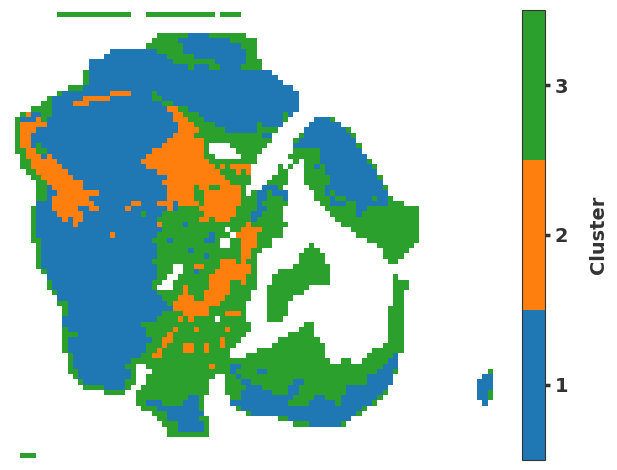

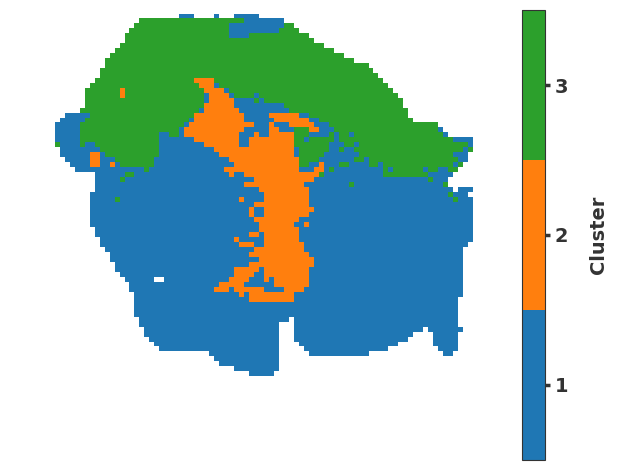

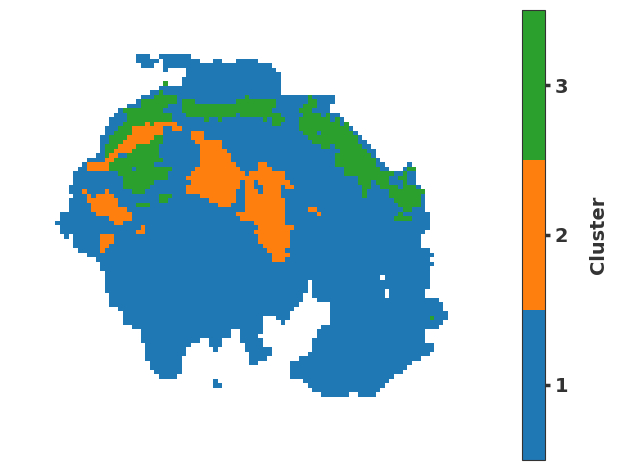

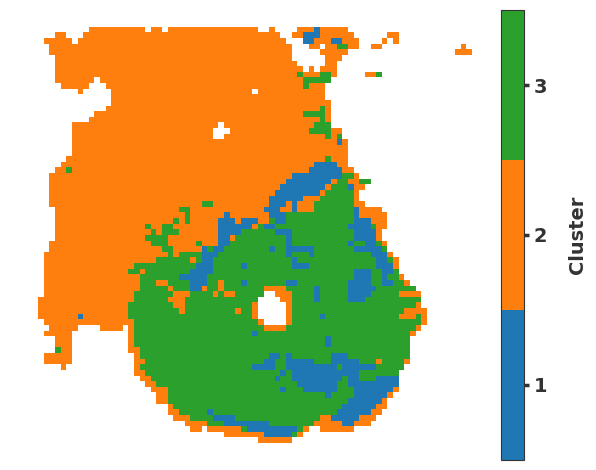

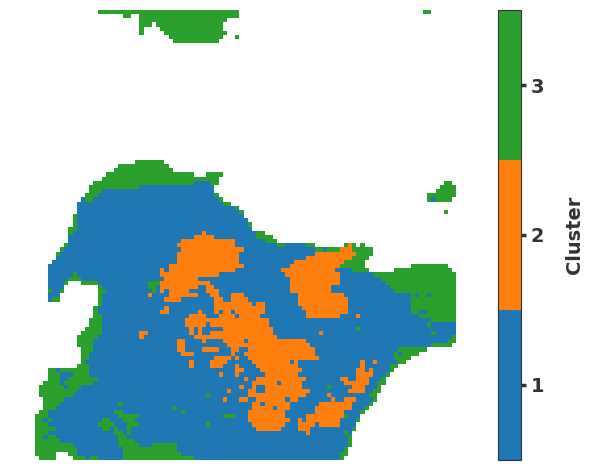

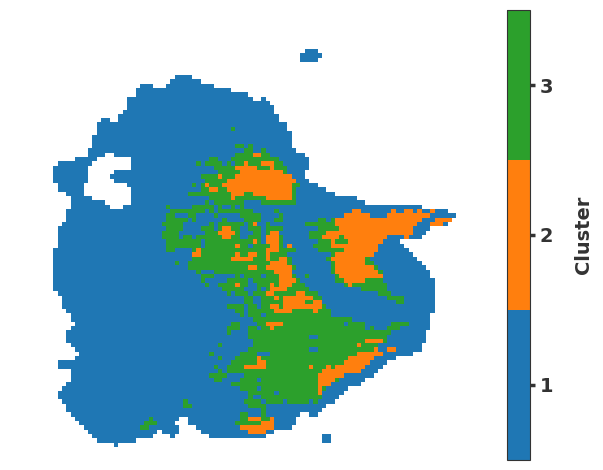

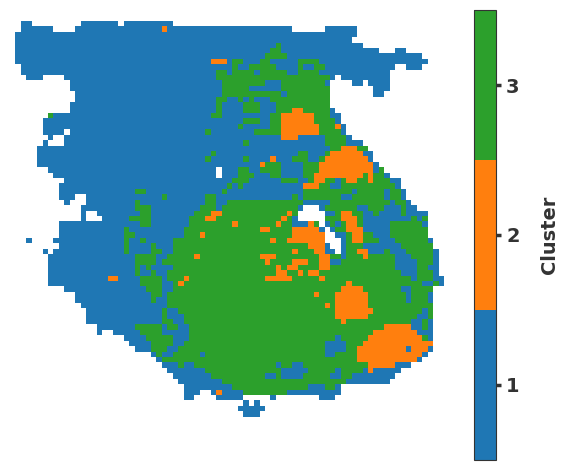

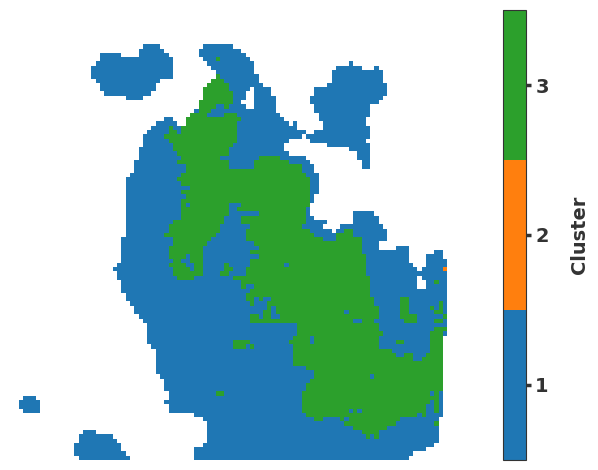

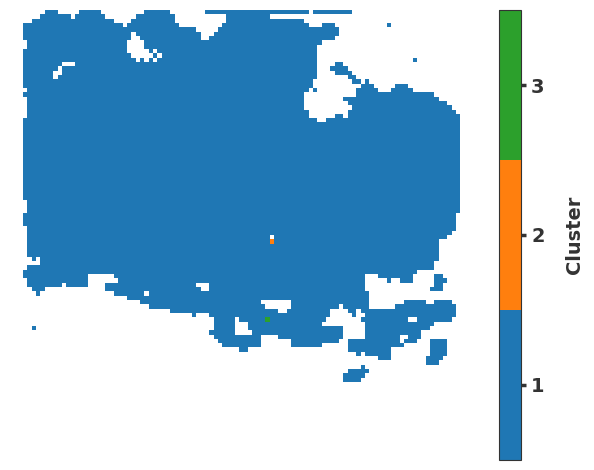

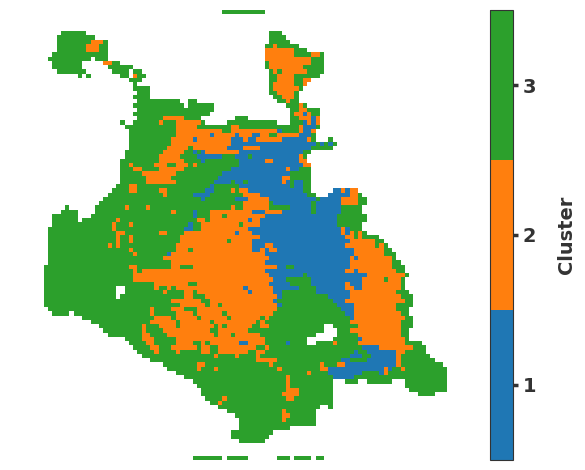

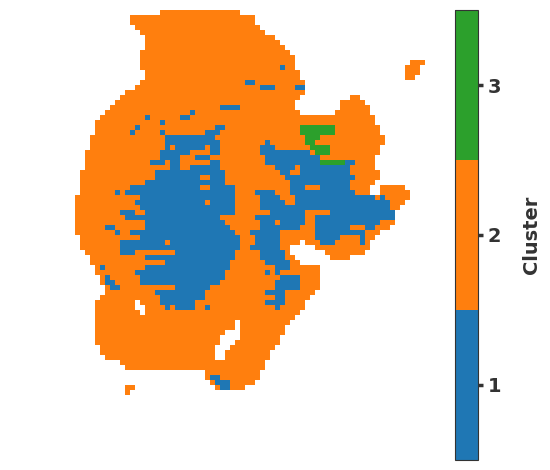

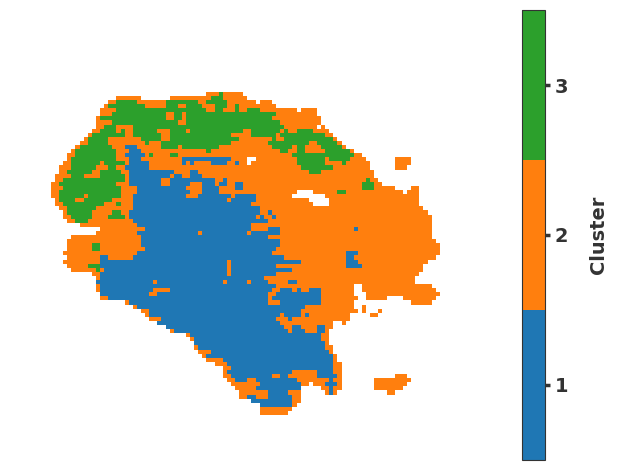

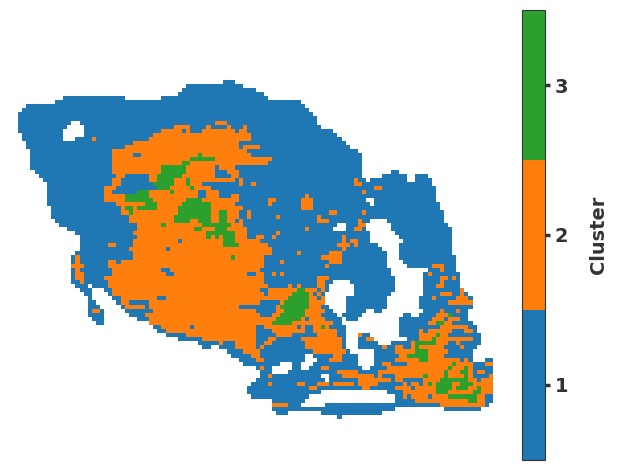

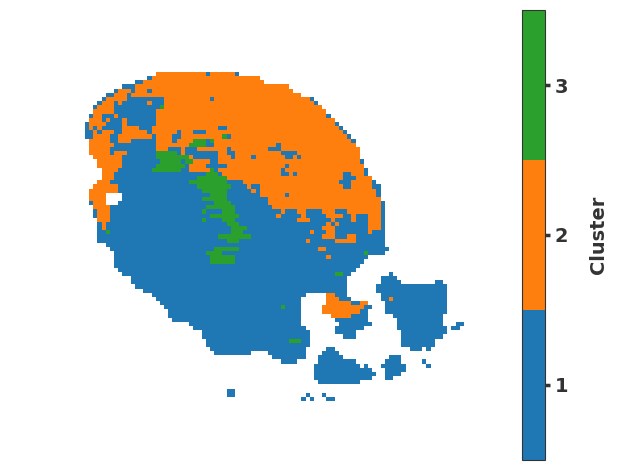

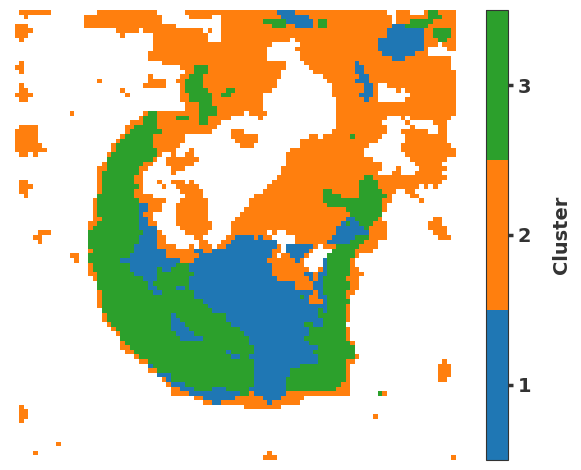

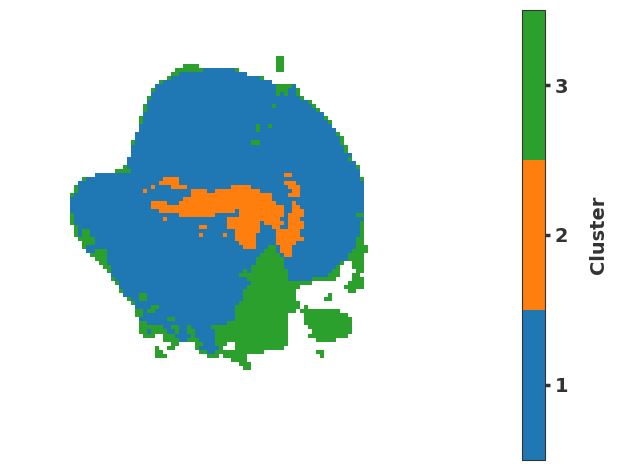

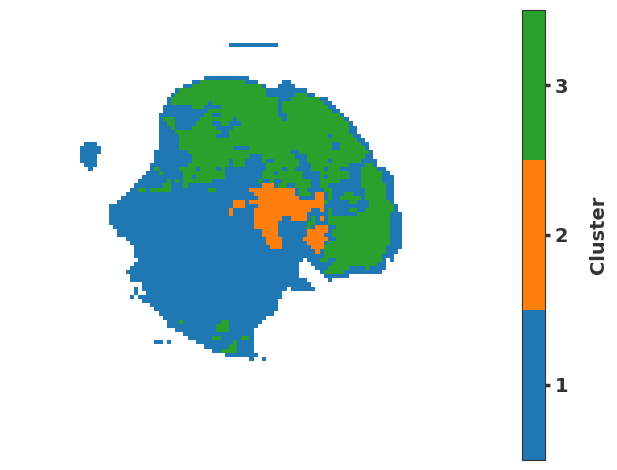

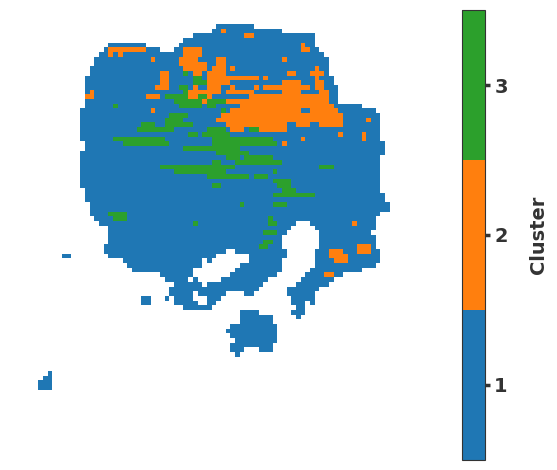

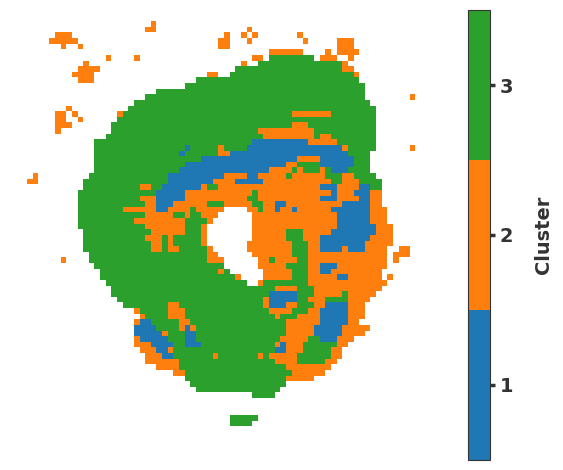

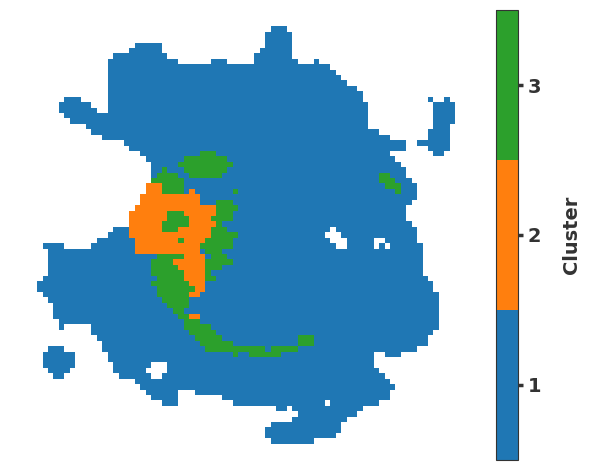

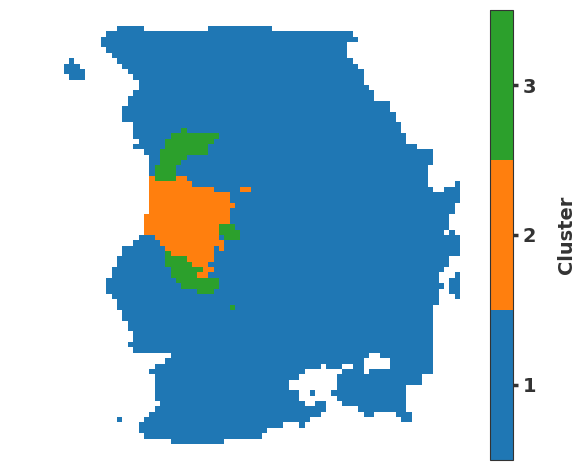

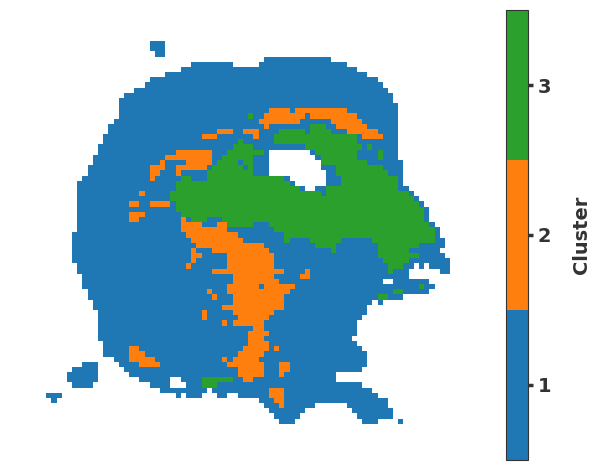

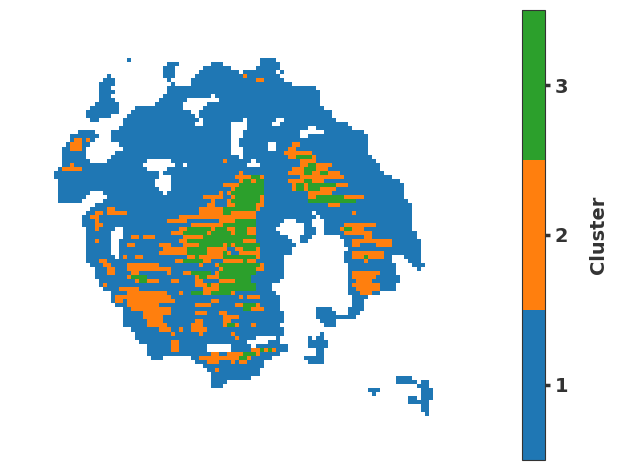

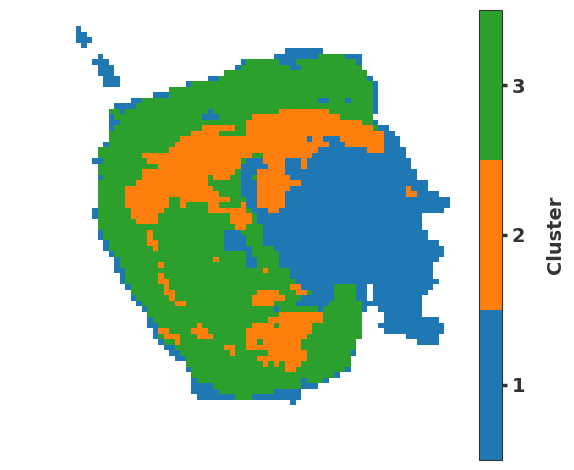

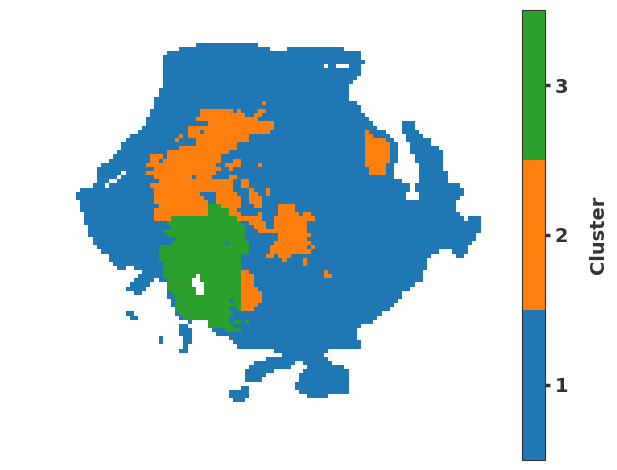

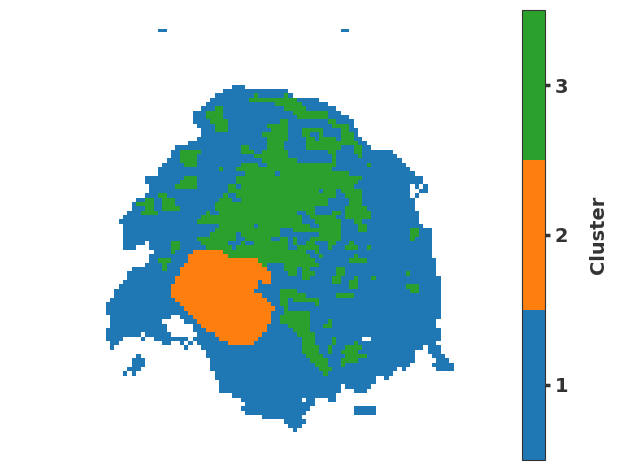

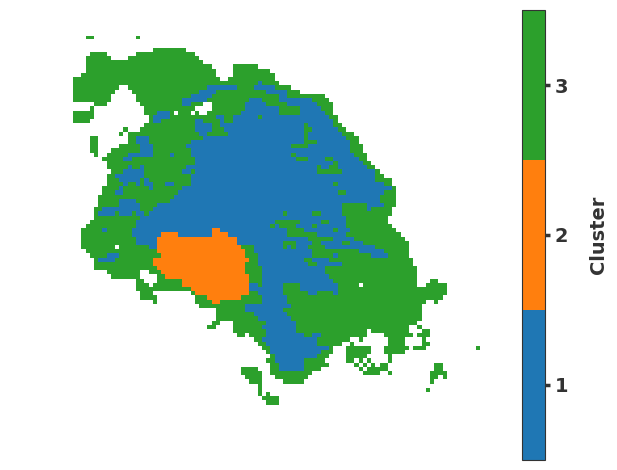

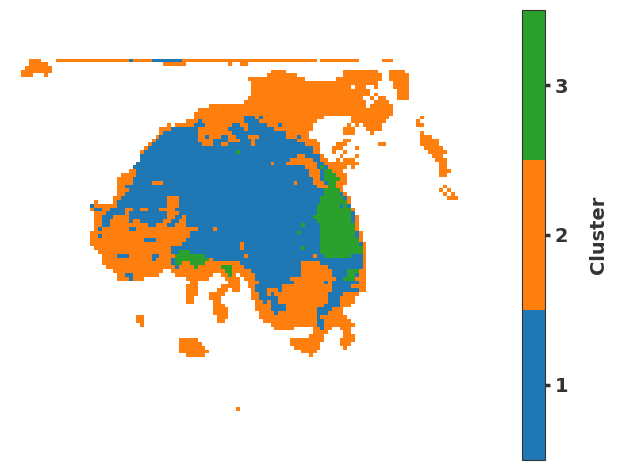

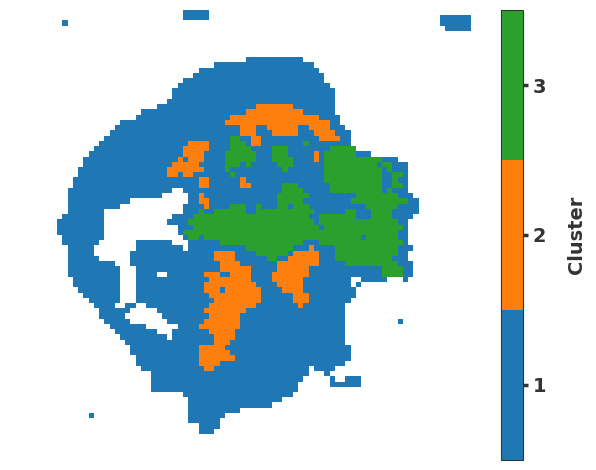

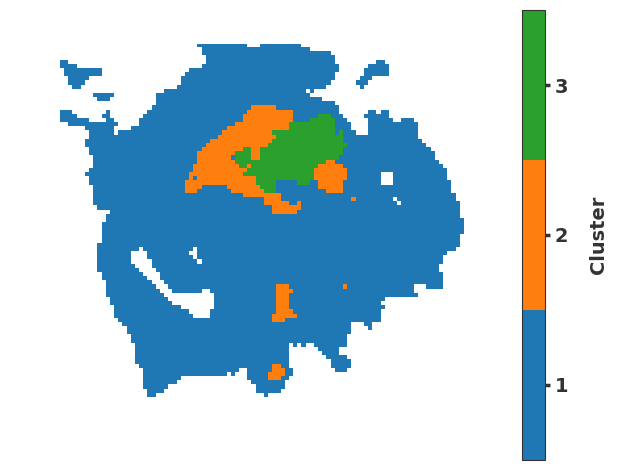

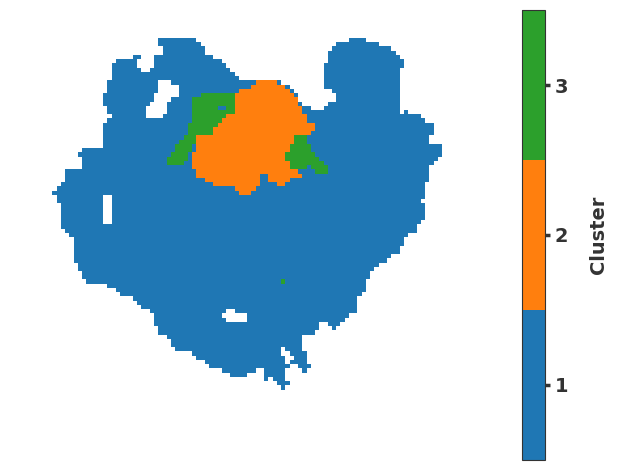

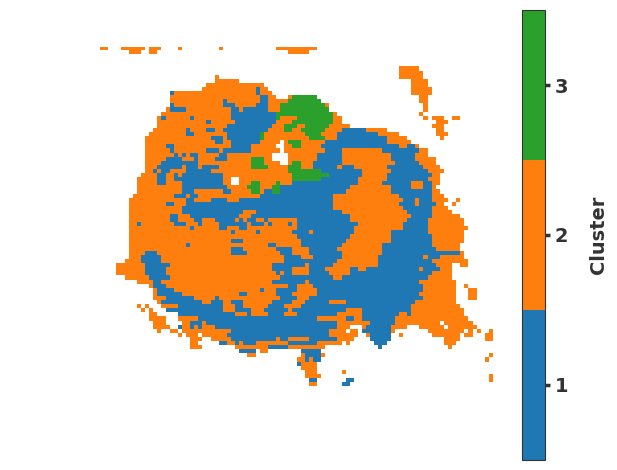

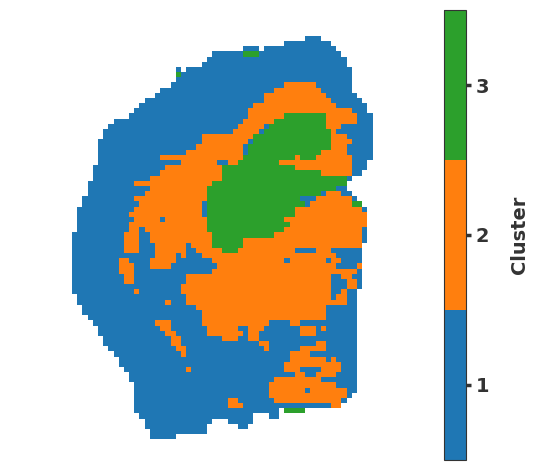

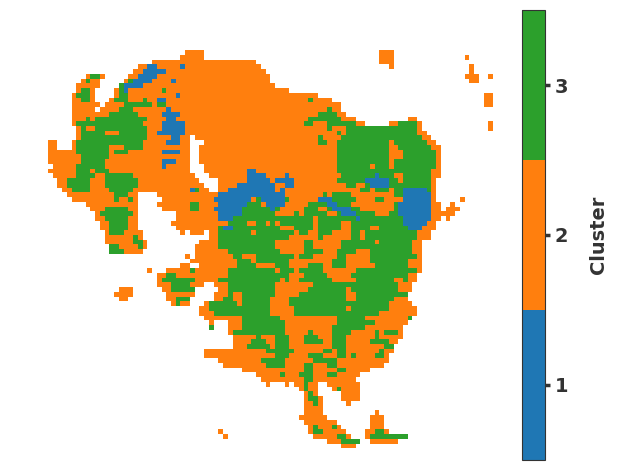

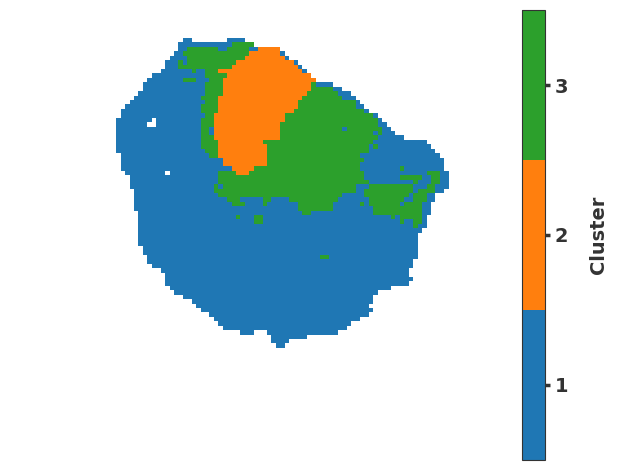

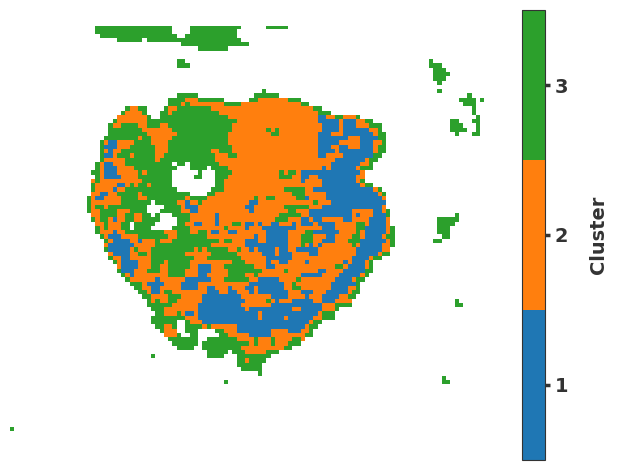

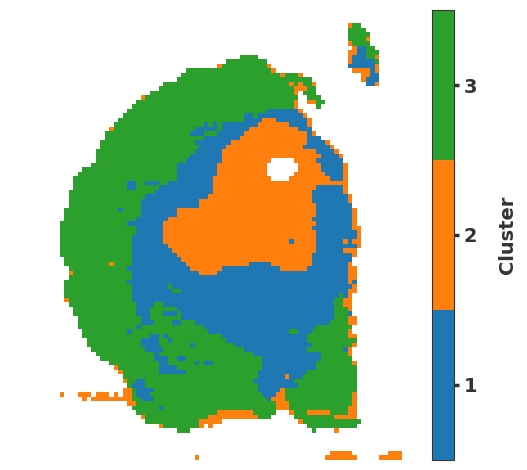

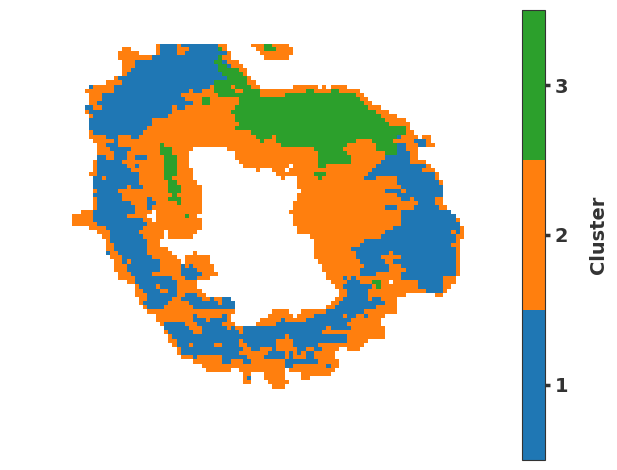

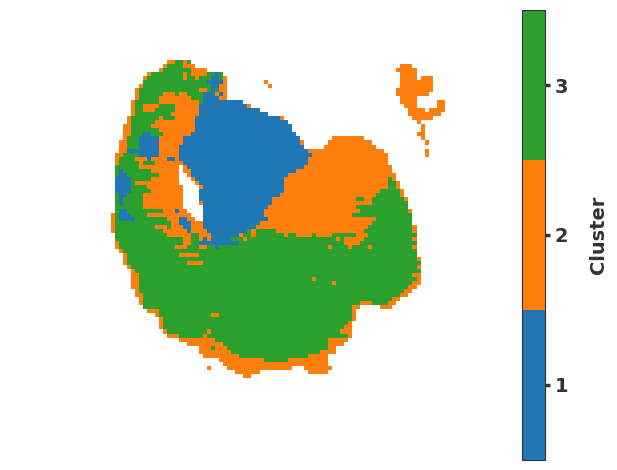

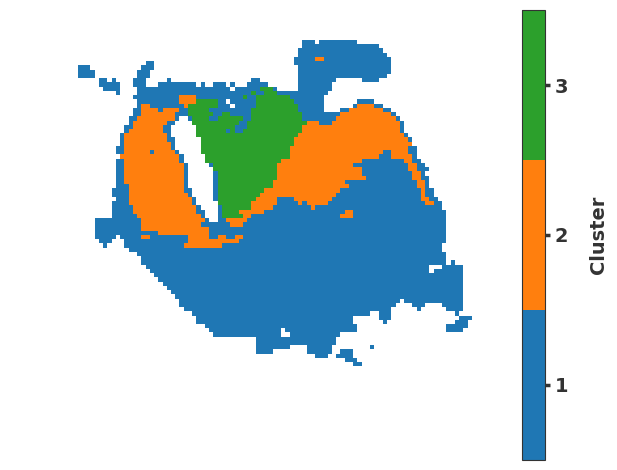

In [3]:
def plot_clusters(labels, mask, original_shape, path, name):
  #
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(n_clusters)]
  colors = np.vstack(([1, 1, 1, 1], selected_colors))
  custom_cmap = ListedColormap(colors)

  # Reshape labels to original image shape
  label_image = np.zeros(original_shape)
  label_image[mask] = labels
  #flipped_label_image = np.fliplr(label_image)
  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  cbar = plt.colorbar(
      seg_c_map, ticks=np.arange(1, n_clusters + 1),
      boundaries=np.arange(0.5, n_clusters + 1.5)
  )
  cbar.set_ticklabels(range(1, n_clusters + 1))
  cbar.set_label(
      'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
  )
  cbar.outline.set_edgecolor('0.2')
  cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
  for l in cbar.ax.get_yticklabels():
    l.set_fontweight('bold')
    l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.savefig(
      path / f"{name}_clusters.png", bbox_inches='tight', dpi=1200,
      transparent=True
  )
  plt.show()


n_clusters = 3
save_path = Path(".") / "longitudinal" / "hca"
save_path.mkdir(parents=True, exist_ok=True)
for folder in PROCESSED_DATA.iterdir():
  if 'tmz' in folder.name and "tumor" in folder.name:
    msi_path = folder / 'meaningful_signal.imzML'
    msi_seg = np.load(folder / "segmentation_new.npy")
    hca_path = Path(".") / "longitudinal" / "hca" / f"{folder.name}_hca.pkl"
    with ImzMLParser(msi_path) as p:
      mzs, img = read_msi(p)
      mzs_filter = (mzs >= 600) & (mzs <= 900)
      img_filter = img[:, :, mzs_filter]

    with open(hca_path, 'rb') as f:
      cluster_model = pickle.load(f)

    plot_clusters(
        cluster_model.labels_ + 1, msi_seg, img_filter.shape[:-1], save_path,
        folder.name
    )

In [19]:
from chip_types_data_analysis import get_spectras

names = ["3_porous_nNs-r", "3_tissue_section-s"]

parsers = {}
masks = {}

for name in names:
  folder = PROCESSED_DATA / name
  parsers[name] = ImzMLParser(folder.joinpath("meaningful_signal.imzML"))
  masks[name] = np.load(folder.joinpath("segmentation.npy"), mmap_mode='r')

spectras = get_spectras(parsers, masks)

In [20]:
spectras_scaled = {
    key: (mzs, (spectra - spectra.min()) / (spectra.max() - spectra.min()))
    for key, (mzs, spectra) in spectras.items()
}

In [14]:
import itertools


def plot_spectras_best_fit_hex(spectras, save_path, file_plot_name_f) -> None:
  """
  Plots the best fit line for the given spectras using hexbin plot and saves the figure.

  Args:
    spectras (Dict[str, Dict[float, List[float]]]): Dictionary of spectras.
    save_path (Path): Path where the best fit plot will be saved.
    file_plot_name_f (Callable): Function to get file plot name.

  """
  # Create directory to save figures
  save_path = save_path.joinpath("best_fit_plots")
  save_path.mkdir(parents=True, exist_ok=True)
  # Define the grid size for hexbin
  gridsize = 20
  # Loop over all combinations
  for i, j in itertools.combinations(spectras.keys(), 2):
    # Create figure
    _, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
    # Calculate the range and suitable limits for the hexbin plot
    range_i = np.percentile(spectras[i][1], [0, 99])
    range_j = np.percentile(spectras[j][1], [0, 99])
    min_axis = min([range_i[0], range_j[0]])
    max_axis = max([range_i[1], range_j[1]])
    ax.set_xlim(min_axis, max_axis)
    ax.set_ylim(min_axis, max_axis)
    # Plot identity diagonal within the new limits
    ax.plot(
        [min_axis, max_axis], [min_axis, max_axis], linestyle='--',
        color='gray', linewidth=2
    )
    # Plot hexbin
    hb = ax.hexbin(
        x=spectras[j][1], y=spectras[i][1], gridsize=gridsize, cmap='Blues',
        bins='log', extent=(min_axis, max_axis, min_axis, max_axis)
    )
    # Plot color bar
    cb = plt.colorbar(hb, ax=ax)
    # Customize colo bar
    cb.ax.tick_params(axis="both", width=2.5)
    for label in cb.ax.get_yticklabels():
      label.set_fontweight('bold')
      label.set_fontsize(8)
      label.set_color('0.2')
    for spine in cb.ax.spines.values():
      spine.set_linewidth(2.5)
      spine.set_color('0.2')
    #cb.set_label('log10(N)', weight="bold", fontsize=14, color='0.2')

    # Customize the spines and labels
    for axis in ['bottom', 'left']:
      ax.spines[axis].set_linewidth(2.5)
      ax.spines[axis].set_color('0.2')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Customize the ticks
    ax.set_xticks([min_axis, max_axis])
    ax.set_yticks([max_axis])
    # Customize the offsetText
    ax.yaxis.offsetText.set_fontweight('bold')
    ax.yaxis.offsetText.set_fontsize(8)
    ax.yaxis.offsetText.set_color('0.2')
    ax.xaxis.offsetText.set_fontweight('bold')
    ax.xaxis.offsetText.set_fontsize(8)
    ax.xaxis.offsetText.set_color('0.2')
    # Apply font settings to tick labels
    for label in ax.get_yticklabels() + ax.get_xticklabels():
      label.set_fontweight('bold')
      label.set_fontsize(8)
      label.set_color('0.2')
    # Set axis labels
    ax.set_ylabel(file_plot_name_f(i), fontsize=14, weight='bold', color='0.2')
    ax.set_xlabel(file_plot_name_f(j), fontsize=14, weight='bold', color='0.2')
    # Remove ticks line
    ax.tick_params(axis='both', length=0, rotation=45)
    # Save the plot
    plt.savefig(
        save_path.joinpath(f"{i}_{j}_hexbin.png"), bbox_inches='tight', dpi=300,
        transparent=True
    )
    # Show the plot
    plt.show()

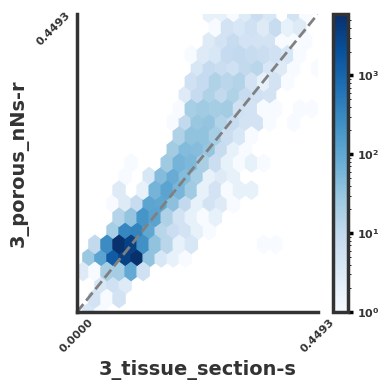

In [21]:
plot_spectras_best_fit_hex(spectras_scaled, Path("."), lambda x: x)

In [2]:
group = [
    "tmz_1_tumor_brain_1_day_0_0_uM", "tmz_1_tumor_brain_1_day_5_0_uM_rep_1",
    "tmz_1_tumor_brain_1_day_5_0_uM_rep_2",
    "tmz_1_tumor_brain_1_day_5_0_uM_rep_3"
]

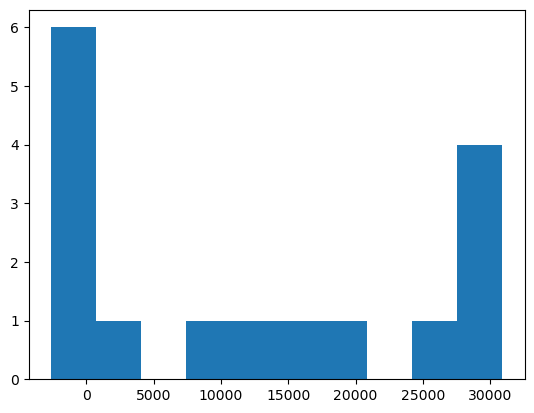

In [44]:
msi_path = PROCESSED_DATA / group[0] / 'meaningful_signal.imzML'
msi_seg = np.load(PROCESSED_DATA / group[0] / "segmentation_new.npy")

with ImzMLParser(msi_path) as p:
  mzs, img = read_msi(p)
  mzs_filter = (mzs >= 600) & (mzs <= 900)
  img_filter = img[:, :, mzs_filter]

plt.hist(
    img_filter[msi_seg][:, (mzs[mzs_filter] >= 834.5 - 0.1) &
                        (mzs[mzs_filter] <= 834.5 + 0.1)].sum(axis=0)
)
plt.show()

In [43]:
s1 = img_filter[:, :, (mzs[mzs_filter] >= 834.5 - 0.1) &
                (mzs[mzs_filter] <= 834.5 + 0.1)][msi_seg].sum(axis=1)

In [45]:
s2 = img_filter[:, :, (mzs[mzs_filter] >= 834.5 - 0.1) &
                (mzs[mzs_filter] <= 834.5 + 0.1)][msi_seg].sum(axis=1)

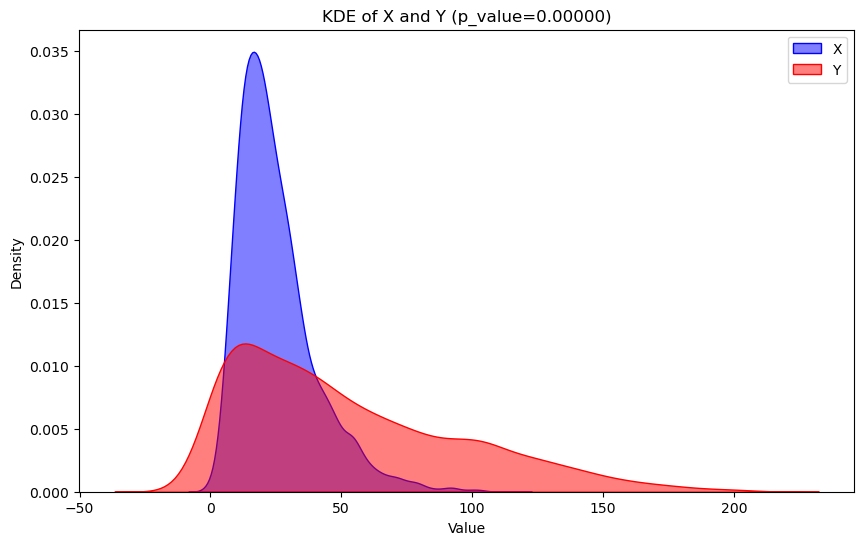

In [51]:
import seaborn as sns
from scipy import stats

ks_statistic, p_value = stats.ks_2samp(s1, s2)

plt.figure(figsize=(10, 6))
sns.kdeplot(s1, label='X', fill=True, color='blue', alpha=0.5)
sns.kdeplot(s2, label='Y', fill=True, color='red', alpha=0.5)
plt.title(f'KDE of X and Y (p_value={p_value:.5f})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [49]:
p_value

3.520838945257828e-270

array([-2120.53068852, -1809.82675922, -1163.49618627, -2101.36849778,
       -2609.13920875, -1684.94962209,  2581.6426721 , 15639.26694074,
       29907.60529245, 30875.43481528, 30346.67144865, 28233.0517089 ,
       24474.71291917, 19127.691104  , 10173.454026  , 13482.48718517])

In [7]:
mean = img_filter[msi_seg].mean(axis=0)
std = img_filter[msi_seg].std(axis=0)

In [12]:
diffs = []

for folder_name in group[1:]:
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

    mean_diffs = np.abs(mean - img_filter[msi_seg].mean(axis=0))
    std_diffs = np.abs(std - img_filter[msi_seg].std(axis=0))

    total_diffs = mean_diffs + std_diffs

    sorted_channel_indices = np.argsort(total_diffs)[::-1]

    diffs.append(mzs[mzs_filter][sorted_channel_indices])

In [16]:
total_diffs

array([0.19569267, 0.28799836, 0.10845181, ..., 0.28216755, 0.49634172,
       0.11543265])

In [14]:
[i[:10] for i in diffs]

[array([654.55625, 834.50625, 834.55625, 774.53125, 775.54375, 835.51875,
        790.51875, 788.54375, 836.53125, 834.51875]),
 array([654.55625, 628.55625, 834.55625, 788.54375, 836.54375, 603.54375,
        601.55625, 788.53125, 789.53125, 834.54375]),
 array([692.44375, 628.55625, 788.54375, 788.53125, 627.53125, 627.54375,
        627.51875, 628.53125, 654.55625, 835.51875])]

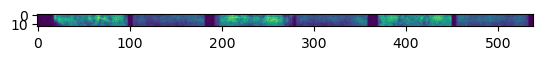

In [40]:
from pyimzml.ImzMLParser import getionimage

with ImzMLParser(RAW_DATA / "210623-pm-0_7 Analyte 1_1.imzml") as p:
  p.imzmldict["max count of pixels x"] += 1
  img = getionimage(p, 886.6, tol=0.1)
  plt.imshow(img)
  plt.show()


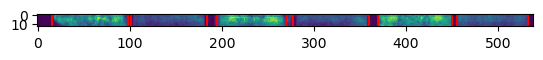

In [36]:
plt.imshow(img)
plt.axvline(x=15, color="red")
plt.axvline(x=98, color="red")
plt.axvline(x=101, color="red")
plt.axvline(x=184, color="red")
plt.axvline(x=195, color="red")
plt.axvline(x=270, color="red")
plt.axvline(x=277, color="red")
plt.axvline(x=360, color="red")
plt.axvline(x=370, color="red")
plt.axvline(x=450, color="red")
plt.axvline(x=455, color="red")
plt.axvline(x=533, color="red")
plt.show()

In [4]:
p.imzmldict["max count of pixels x"] -= 1

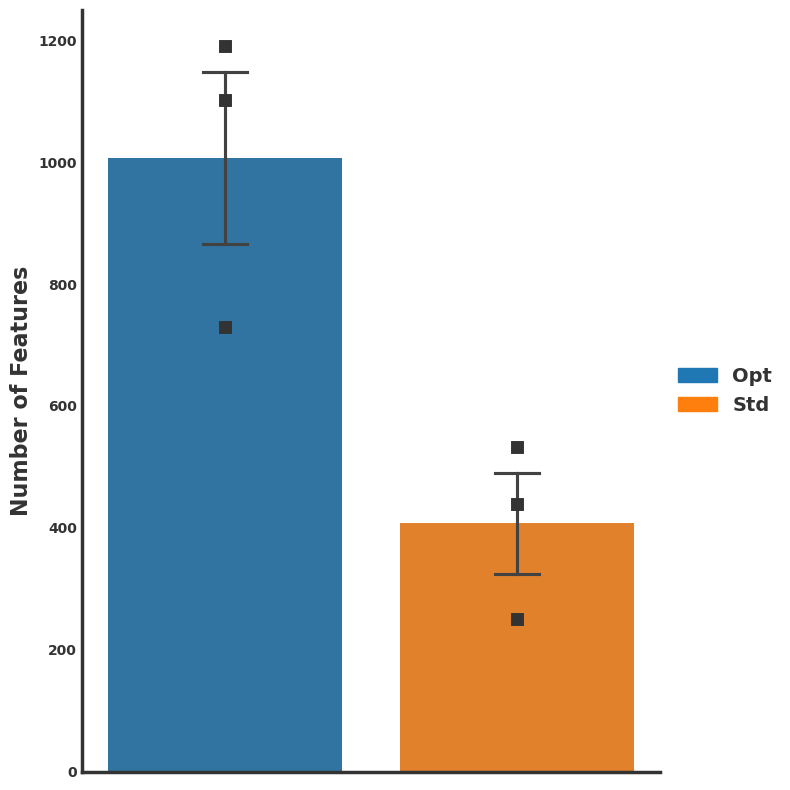

In [7]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Patch


def plot_num_features(
    num_features: pd.DataFrame, threshold: float, save_path: Path
):
  """Plots and saves a bar chart comparing the number of features between chip
  types in a certain threshold.

  Args:
    num_features_df (pd.DataFrame): dataframe containing the number of features
        in each threshold for each parser.
    threshold (float): The threshold for determining significance.
    save_path (Path): Path object where the output image will be saved.
  """
  # Get number of features for corresponding peak threshold
  num_features = num_features[num_features["Peak Threshold"] == threshold]
  # Now we plot the bars for the mean and add error bars for the SEM.
  _, ax = plt.subplots(1, 1, figsize=(8, 8))
  # create color palette
  palette_dict = {
      label: color for label, color in
      zip(num_features['Type'].unique(), sns.color_palette())
  }
  # Create a bar plot using seaborn with custom error bars
  ax = sns.barplot(
      data=num_features, x="Type", y="Number of Features", hue="Type",
      errorbar=lambda x: (x.mean() - x.sem(), x.mean() + x.sem()), capsize=0.15,
      palette=palette_dict
  )
  sns.scatterplot(
      data=num_features, x="Type", y="Number of Features", legend=False,
      zorder=10, color='0.2', edgecolor='0.2', marker='s', s=70
  )
  # Customize the spines
  for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  # Customize ticks
  plt.xticks(fontsize=10, fontweight='bold', color='0.2')
  plt.xticks(rotation=45)
  plt.yticks(fontsize=10, fontweight='bold', color='0.2')
  ax.set_xticklabels([])
  # Add legend to the plot with a title
  legend_patches = [
      Patch(color=color, label=label) for label, color in palette_dict.items()
  ]
  leg = ax.legend(
      loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True,
      shadow=True, handles=legend_patches, prop={"size": 14}
  )

  leg.set_frame_on(False)
  # Sort legend
  for line in leg.get_lines():
    line.set_linewidth(3.5)
  for text in leg.get_texts():
    text_parts = text.get_text().split("_")
    if len(text_parts) > 2:
      parts_new = []
      for i in range(0, len(text_parts), 2):
        parts_new.append(" ".join(text_parts[i:i + 2]))
      text.set_text("\n".join(parts_new).capitalize())
    else:
      text.set_text(" ".join(text_parts).capitalize())
    text.set_weight('bold')
    text.set_color('0.2')
  # Remove ticks line
  ax.tick_params(axis='both', length=0)
  # Set labels
  ax.set_ylabel('Number of Features', fontsize=16, weight='bold', color='0.2')
  ax.set_xlabel("")
  # Add space between subplots and show the plot
  plt.tight_layout()
  # Save the plot
  plt.savefig(
      save_path.joinpath("number_of_features_bar_graph.png"),
      bbox_inches='tight', dpi=1200, transparent=True
  )
  # Display the plot
  plt.show()

num_features = pd.read_csv(Path(".") / "liver/" / "num_features.csv")
plot_num_features(num_features, 2, Path(".") / "liver/")

In [2]:
for folder in PROCESSED_DATA.iterdir():
  print(f"'{folder.name}': [],")

'liver_opt_1': [],
'liver_opt_2': [],
'liver_opt_3': [],
'liver_std_1': [],
'liver_std_2': [],
'liver_std_3': [],


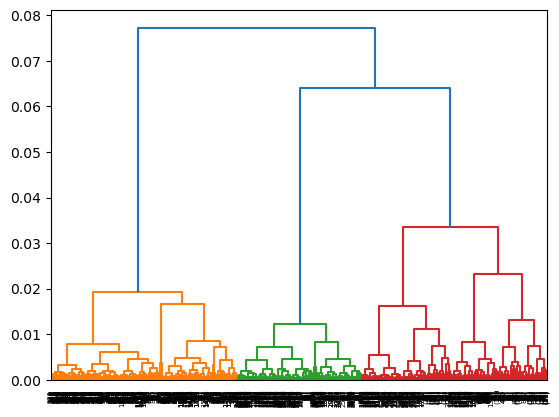

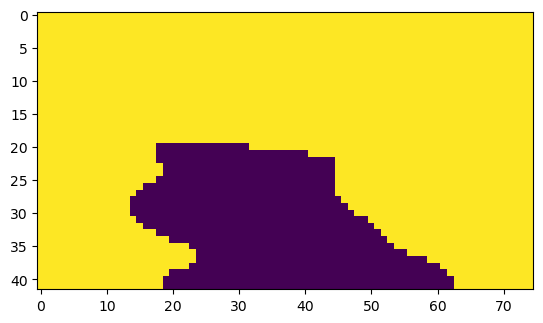

In [7]:
import pickle
from scipy.cluster.hierarchy import dendrogram, fcluster


def plot_dendrogram(model, **kwargs):

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  labels = fcluster(linkage_matrix, kwargs.get('p', 2), criterion='maxclust')

  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, **kwargs)
  plt.show()

  return labels


folder = list(PROCESSED_DATA.iterdir())[3]
model_path = folder / "hca_common_representation.pkl"
file = folder / "common_representation.imzML"
selected_labels_path = folder / "hca_common_representation_bg_labels.npy"

selected_labels = np.load(selected_labels_path, mmap_mode='r')

with open(model_path, 'rb') as f:
  model = pickle.load(f)

with ImzMLParser(file) as p:
  mzs, img = read_msi(p)

  labels = plot_dendrogram(model, truncate_mode="level", p=10)
  seg = labels.reshape(img.shape[:-1])

  mask = np.isin(seg, selected_labels)

  plt.imshow(mask)
  plt.show()

In [6]:
list(PROCESSED_DATA.iterdir())[3]

PosixPath('../data/LIVER/processed/liver_std_1')

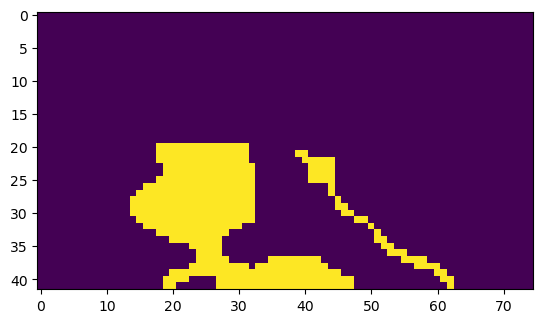

In [13]:
plt.imshow(np.isin(seg, [4]))

In [24]:
np.arange(1.0, 3.1, 0.2)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])

[877.91875 878.91875 877.93125 877.90625 878.93125 885.54375 879.93125
 879.91875 633.39375 877.94375 878.94375 602.38125 879.94375 885.55625
 879.90625 880.93125 880.91875 712.94375 662.94375 762.94375 877.89375
 633.40625 878.90625 792.51875 602.36875 660.41875 792.53125 612.94375
 618.95625 709.73125 634.40625 794.54375 862.93125 886.54375 886.55625
 762.50625 635.40625 880.94375 612.95625 603.38125 691.44375 633.38125
 600.39375 877.95625 627.48125 792.54375 885.53125 880.90625 790.53125
 840.53125 662.95625 629.49375 691.43125 684.60625 725.73125 617.41875
 812.94375 885.56875 718.94375 762.51875]


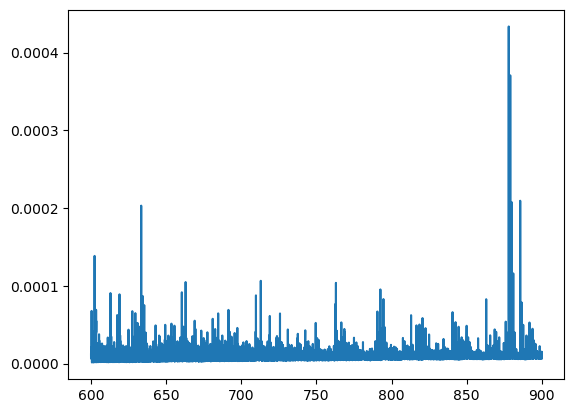

In [14]:
mzs_filter = (mzs >= 600) & (mzs <= 900)
new_mzs = mzs[mzs_filter]
mean =np.mean (img[np.isin(seg, [7])], axis=0)[mzs_filter]
print(new_mzs[mean.argsort()[-60:][::-1]])
plt.plot(new_mzs, mean)
plt.show()

In [15]:
new_mzs[mean.argsort()[-60:][::-1]]

array([877.91875, 878.91875, 877.93125, 877.90625, 878.93125, 885.54375,
       879.93125, 879.91875, 633.39375, 877.94375, 878.94375, 602.38125,
       879.94375, 885.55625, 879.90625, 880.93125, 880.91875, 712.94375,
       662.94375, 762.94375, 877.89375, 633.40625, 878.90625, 792.51875,
       602.36875, 660.41875, 792.53125, 612.94375, 618.95625, 709.73125,
       634.40625, 794.54375, 862.93125, 886.54375, 886.55625, 762.50625,
       635.40625, 880.94375, 612.95625, 603.38125, 691.44375, 633.38125,
       600.39375, 877.95625, 627.48125, 792.54375, 885.53125, 880.90625,
       790.53125, 840.53125, 662.95625, 629.49375, 691.43125, 684.60625,
       725.73125, 617.41875, 812.94375, 885.56875, 718.94375, 762.51875])

In [ ]:
representative_peaks = {
    '1_flat_porous_substrate-r': [861.89375, 848.89375, 862.85625], '1_porous_nNs_with_porous_substrate-r': [600.51, 768.51, 885.55],
    '1_porous_nNs-r': [794.5, 834.5, 886.6], '1_solid_nNs-r': [627.53, 834.56, 886.66], '1_tissue_section-s': [],
    '2_flat_porous_substrate-r': [], '2_porous_nNs_with_porous_substrate-r': [],
    '2_porous_nNs-r': [], '2_solid_nNs-r': [], '2_tissue_section-s': [],
    '3_flat_porous_substrate-r': [], '3_porous_nNs_with_porous_substrate-r': [],
    '3_porous_nNs-r': [], '3_solid_nNs-r': [], '3_tissue_section-s': []
}

In [265]:
for _, roi in pd.read_csv(BASE_PATH / "metadata.csv").iterrows():
  print(roi.sample_file_name)

1_flat_porous_substrate-r
1_porous_nNs_with_porous_substrate-r
1_porous_nNs-r
1_solid_nNs-r
1_tissue_section-s
2_flat_porous_substrate-r
2_porous_nNs_with_porous_substrate-r
2_porous_nNs-r
2_solid_nNs-r
2_tissue_section-s
3_flat_porous_substrate-r
3_porous_nNs_with_porous_substrate-r
3_porous_nNs-r
3_solid_nNs-r
3_tissue_section-s


[794.5, 834.5, 886.6] 0.40993788819875776


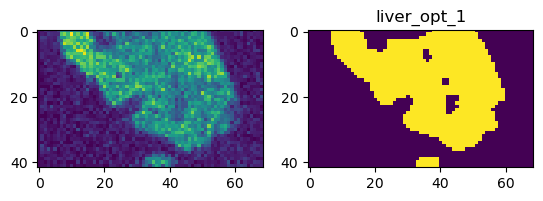

[794.5, 834.5, 886.6] 0.4050751879699248


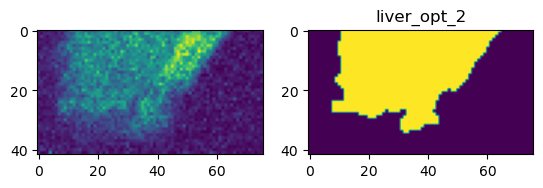

[794.5, 834.5, 886.6] 0.40934065934065933


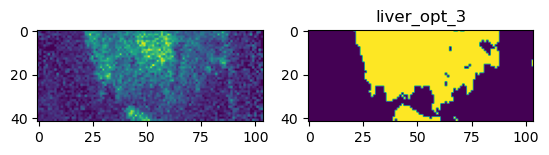

[634.4, 794.54, 886.55] 0.34253968253968253


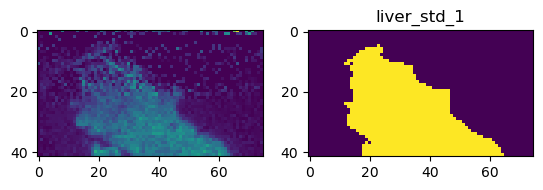

[634.4, 794.54, 886.55] 0.5277275467148885


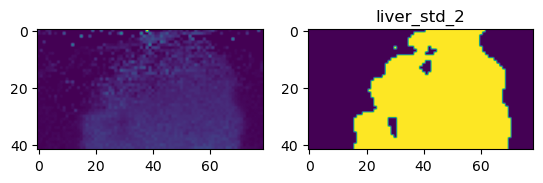

[634.4, 794.54, 886.55] 0.49523809523809526


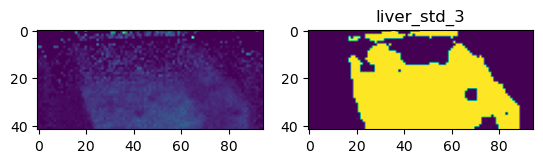

In [18]:
mz = 794.5
thresh = 0.025

representative_peaks_map = {
    'std': [634.40, 794.54, 886.55], 'opt': [794.5, 834.5, 886.6]
}

for folder in PROCESSED_DATA.iterdir():
  representative_peaks = next(
      (
          value for key, value in representative_peaks_map.items()
          if key in folder.name
      ), None
  )

  msi_path = folder / 'common_representation.imzML'
  # Parse the msi file
  with ImzMLParser(msi_path) as reader:
    # Get full msi
    mzs, img = read_msi(reader)
    #
    mean_seg = MeanSegmentation(mzs, representative_peaks, thresh).segment(img)
    print(
        representative_peaks,
        mean_seg.sum() / (mean_seg.shape[0] * mean_seg.shape[1])
    )
    #
    filter_mz = (mzs >= mz - thresh) & (mzs <= mz + thresh)
    #
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img[:, :, filter_mz].sum(axis=-1))
    axes[1].imshow(mean_seg)
    plt.title(folder.name)
    plt.show()

(634.4, 794.54, 886.55) 0.5277275467148885


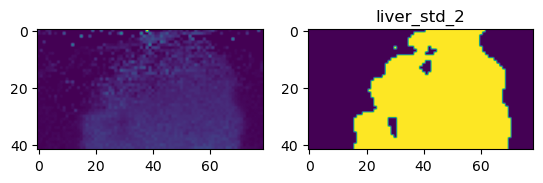

(634.4, 794.54, 762.5) 0.5379746835443038


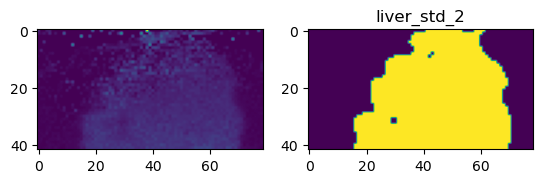

(634.4, 794.54, 627.48) 0.5569620253164557


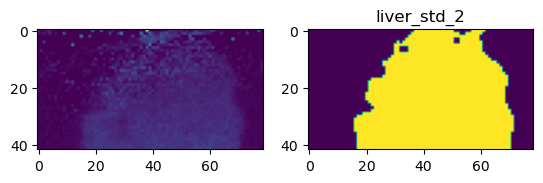

(634.4, 794.54, 684.6) 0.5548523206751055


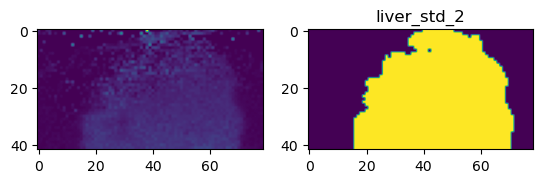

(634.4, 794.54, 762.51) 0.5379746835443038


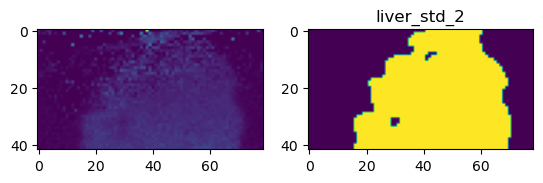

(634.4, 886.55, 762.5) 0.5027124773960217


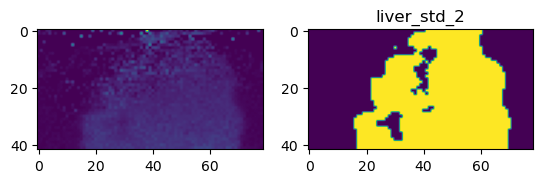

(634.4, 886.55, 627.48) 0.5162748643761302


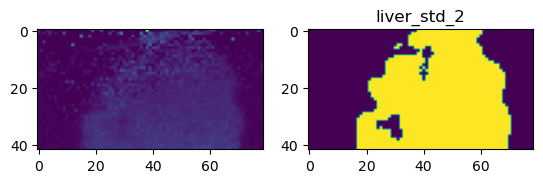

(634.4, 886.55, 684.6) 0.523508137432188


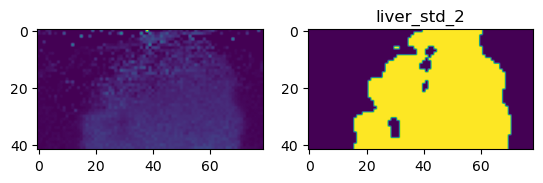

(634.4, 886.55, 762.51) 0.5057263411693791


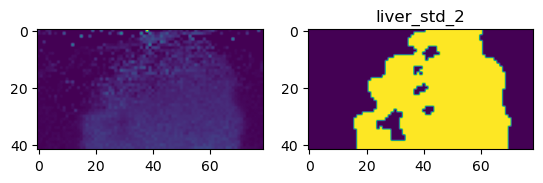

(634.4, 762.5, 627.48) 0.5316455696202531


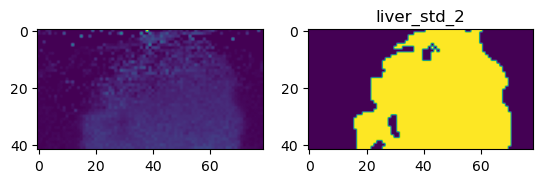

(634.4, 762.5, 684.6) 0.5355635925256178


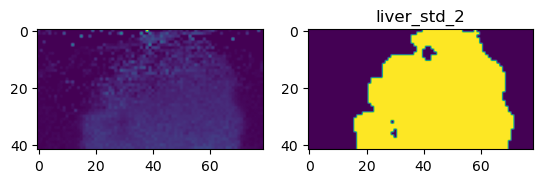

(634.4, 762.5, 762.51) 0.5165762507534659


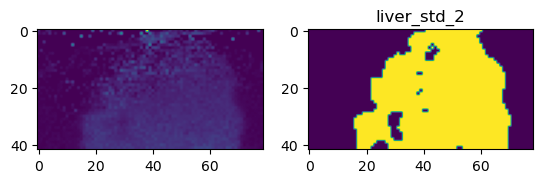

(634.4, 627.48, 684.6) 0.5626883664858349


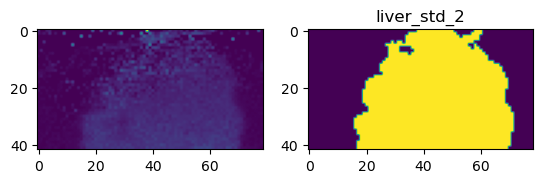

(634.4, 627.48, 762.51) 0.5244122965641953


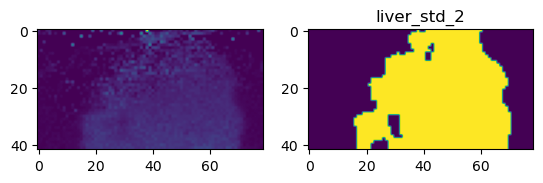

(634.4, 684.6, 762.51) 0.5370705244122965


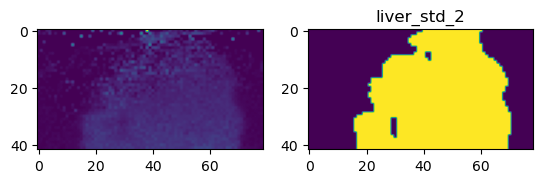

(794.54, 886.55, 762.5) 0.5238095238095238


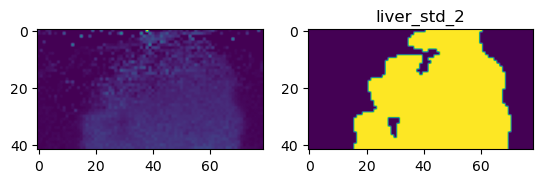

(794.54, 886.55, 627.48) 0.5304400241109102


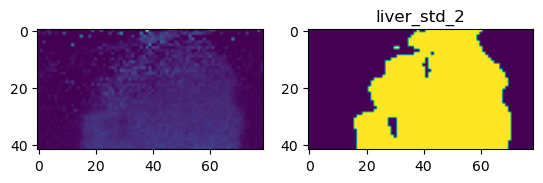

(794.54, 886.55, 684.6) 0.5349608197709463


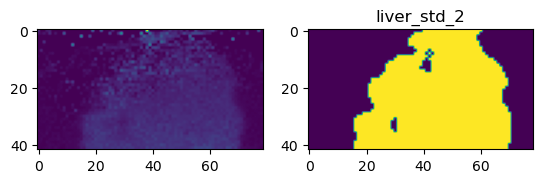

(794.54, 886.55, 762.51) 0.5238095238095238


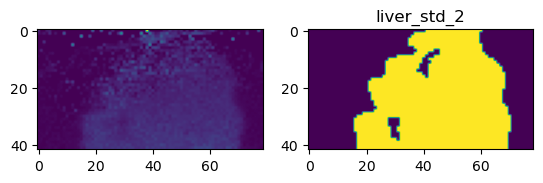

(794.54, 762.5, 627.48) 0.5376732971669681


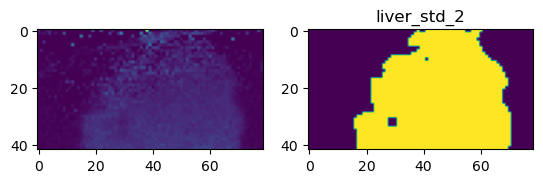

(794.54, 762.5, 684.6) 0.5394816154309825


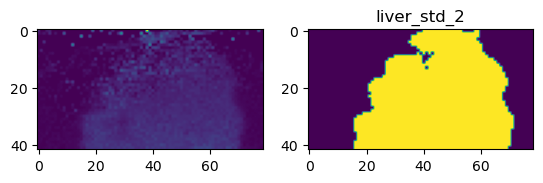

(794.54, 762.5, 762.51) 0.5373719107896323


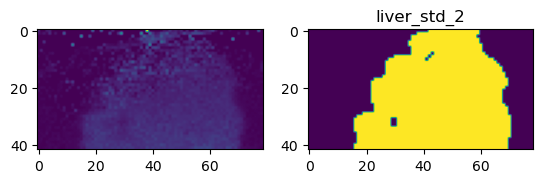

(794.54, 627.48, 684.6) 0.5485232067510548


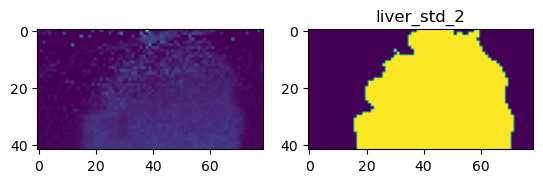

(794.54, 627.48, 762.51) 0.5394816154309825


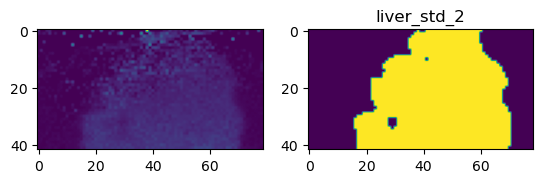

(794.54, 684.6, 762.51) 0.5443037974683544


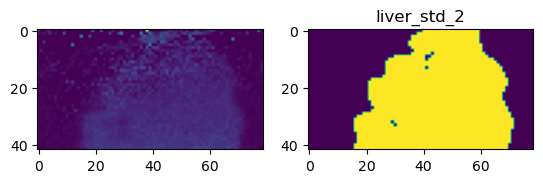

(886.55, 762.5, 627.48) 0.5138637733574443


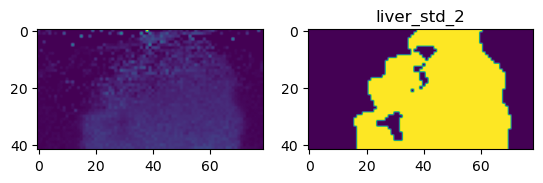

(886.55, 762.5, 684.6) 0.5220012055455093


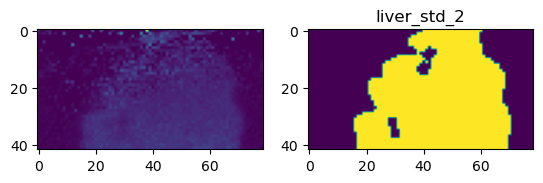

(886.55, 762.5, 762.51) 0.49276672694394213


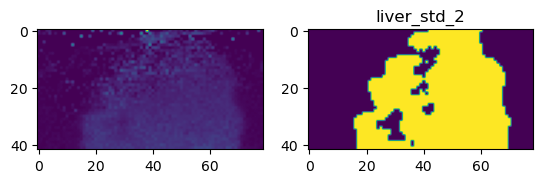

(886.55, 627.48, 684.6) 0.5226039783001808


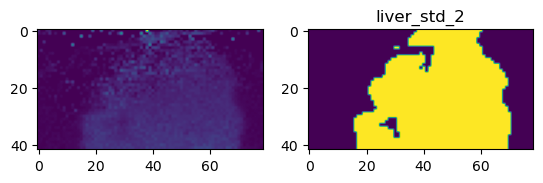

(886.55, 627.48, 762.51) 0.517781796262809


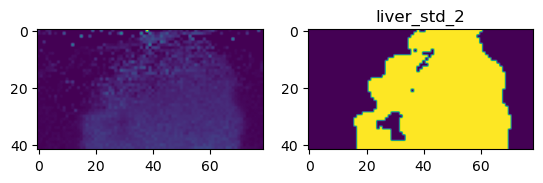

(886.55, 684.6, 762.51) 0.5213984327908379


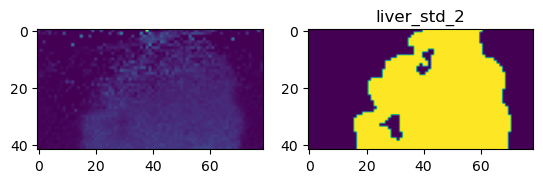

(762.5, 627.48, 684.6) 0.541289933694997


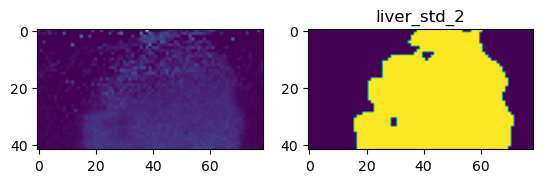

(762.5, 627.48, 762.51) 0.5171790235081374


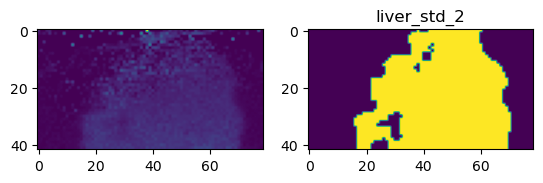

(762.5, 684.6, 762.51) 0.5349608197709463


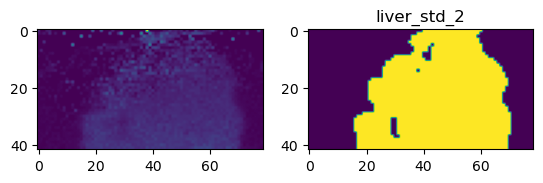

(627.48, 684.6, 762.51) 0.541289933694997


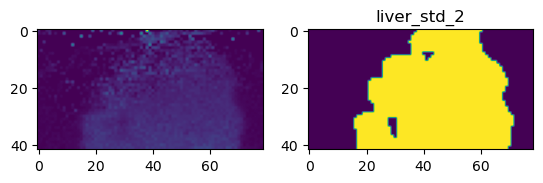

In [19]:
import itertools

flat = [699.9, 834.5, 835.5, 600.5, 861.89375, 795.54375, 848.89375, 862.85625]
substrate = [
    600.51, 601.51, 602.1, 769.54, 768.51, 885.55, 834.55, 886.55, 795.5, 766.5,
    628.55, 654.55, 655.55
]
solid = [768.53, 769.54, 768.51, 627.53, 834.56, 600.51, 794.56, 886.66]

std = [634.40, 794.54, 886.55, 762.5, 627.48, 684.60, 762.51]

for seg_msz in list(itertools.combinations(std, 3)):
  thresh = 0.025

  for folder in list(PROCESSED_DATA.iterdir())[4:]:
    msi_path = folder / 'common_representation.imzML'
    # Parse the msi file
    with ImzMLParser(msi_path) as reader:
      # Get full msi
      mzs, img = read_msi(reader)
      #
      mean_seg = MeanSegmentation(mzs, seg_msz, thresh).segment(img)
      print(seg_msz, mean_seg.sum() / (mean_seg.shape[0] * mean_seg.shape[1]))
      #
      filter_mz = (mzs >= mz - thresh) & (mzs <= mz + thresh)
      #
      fig, axes = plt.subplots(1, 2)
      axes[0].imshow(img[:, :, filter_mz].sum(axis=-1))
      axes[1].imshow(mean_seg)
      plt.title(folder.name)
      plt.show()
    break


In [136]:
mean_seg.sum() / (mean_seg.shape[0] * mean_seg.shape[1])

0.3034750337381916

In [23]:
np.arange(1.0, 3.1, 0.2)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])

In [1]:
###### import os
import sys

sys.path.append(".")

import os
import numpy as np
import pandas as pd
from utils import read_msi, get_mean_spectra
from pyimzml.ImzMLWriter import ImzMLWriter
from pyimzml.ImzMLParser import ImzMLParser
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "DHG"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
means = {}
for f in PROCESSED_DATA.iterdir():
  imzml_file = f / "meaningful_signal.imzML"
  mask = np.load(f / "segmentation.npy")
  with ImzMLParser(imzml_file) as p:
    mzs, img = read_msi(p)
    means[f.name] = np.mean(img[mask], axis=0)[(mzs >= 600) & (mzs <= 900)]

In [3]:
means_r = {key: value for key, value in means.items() if '-r' in key}
means_s = {key: value for key, value in means.items() if '-s' in key}

In [4]:
metadata = pd.read_csv(BASE_PATH / "metadata.csv")
metadata_r = metadata[metadata.sample_type == "replica"]
metadata_s = metadata[metadata.sample_type == "section"]

Accuracy: 0.6499999999999999


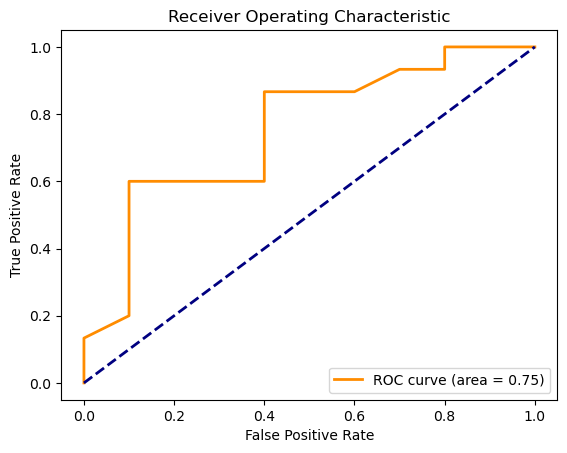

Accuracy: 0.5833333333333333


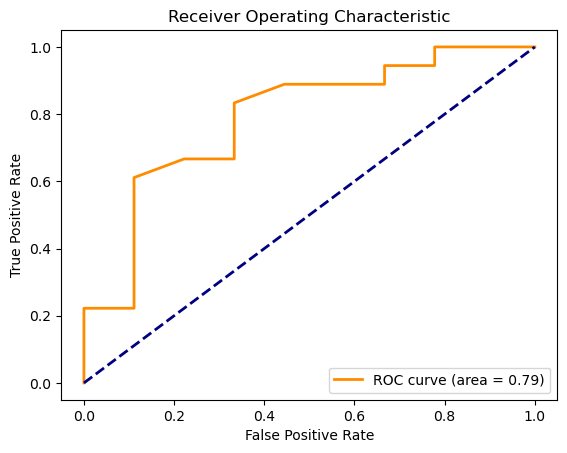

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve

SEED = 42

for metadata_c, means_c in zip([metadata_r, metadata_s], [means_r, means_s]):
  pred_name = []
  pred_label = []
  pred_prob = []
  for exclude_image, group in metadata_c.groupby("file_name"):
    train_name = []
    train_x = []
    train_y = []
    test_name = []
    test_x = []
    test_y = []
    for key, value in means_c.items():
      sample_number = metadata_c[metadata_c.sample_file_name == key
                                ].sample_number.iloc[0]
      sample_label = int(
          metadata_c[metadata_c.sample_file_name == key].who_grade.iloc[0] > 2
      )
      if sample_number in group.sample_number.to_list():
        #vec = [np.mean(bin) for bin in np.array_split(value, 1000)]
        test_name.append(key)
        test_x.append(value)
        test_y.append(sample_label)
      else:
        #vec = [np.mean(bin) for bin in np.array_split(value, 1000)]
        train_name.append(key)
        train_x.append(value)
        train_y.append(sample_label)

    neg, pos = np.bincount(train_y)
    weight_for_0 = (1 / neg) * ((neg + pos) / 2.0)
    weight_for_1 = (1 / pos) * ((neg + pos) / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    scaler = MinMaxScaler(clip=True)

    base_estimator = tree.DecisionTreeClassifier(class_weight=class_weight)
    #classifier = LogisticRegression(max_iter=500)
    #classifier = KNeighborsClassifier()
    classifier = RandomForestClassifier(class_weight=class_weight)
    classifier.fit(scaler.fit_transform(train_x), train_y)

    prob_y = classifier.predict_proba(scaler.transform(test_x))[:, 0]

    pred_name.extend(test_name)
    pred_label.extend(test_y)
    pred_prob.extend(prob_y)

  accuracy = balanced_accuracy_score(pred_label, np.array(pred_prob) > 0.5)
  print("Accuracy:", accuracy)
  auc = roc_auc_score(pred_label, pred_prob)
  # Generate ROC curve data
  fpr, tpr, thresholds = roc_curve(pred_label, pred_prob)

  # Plot the ROC curve
  plt.figure()
  plt.plot(
      fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc
  )
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [168]:
np.bincount(train_y)

array([ 9, 14])

In [148]:
len(train_y[0])

1000

In [143]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = []
C = []
N = []
for key, value in means_r.items():
  sample_label = int(
      metadata_r[metadata_r.sample_file_name == key].who_grade.iloc[0] > 2
  )
  X.append(value)
  C.append(sample_label)
  N.append(key)

scaler = MinMaxScaler()
# pca = TSNE(n_components=2, perplexity=10)
pca = PCA(n_components=2)
X_r = pca.fit_transform(scaler.fit_transform(X))

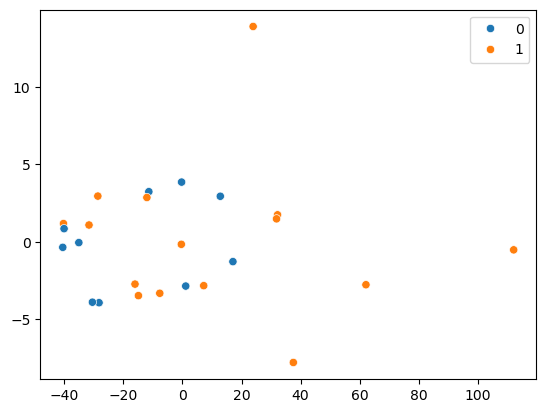

In [144]:
import seaborn as sns

sns.scatterplot(x=X_r[:, 0], y=X_r[:, 1], hue=C)
plt.show()

In [106]:
len(pred_prob)

27

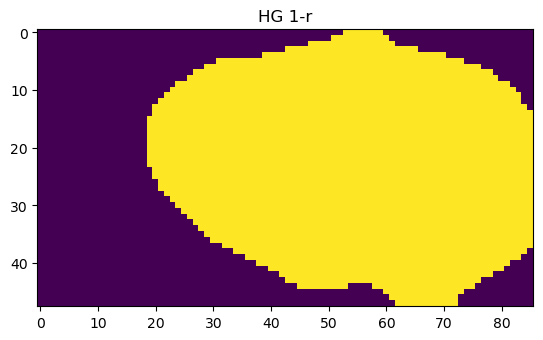

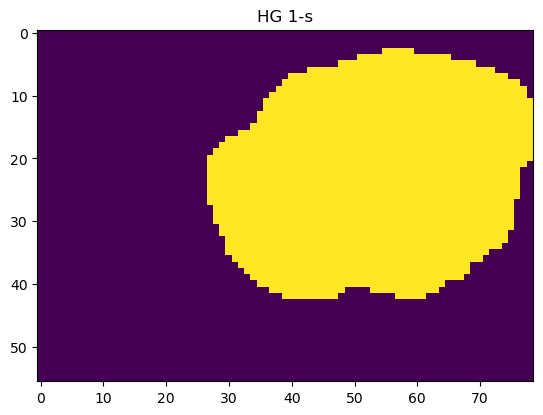

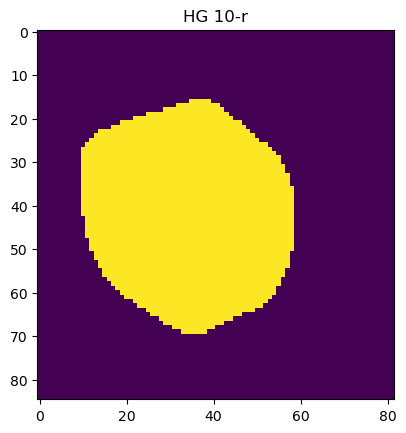

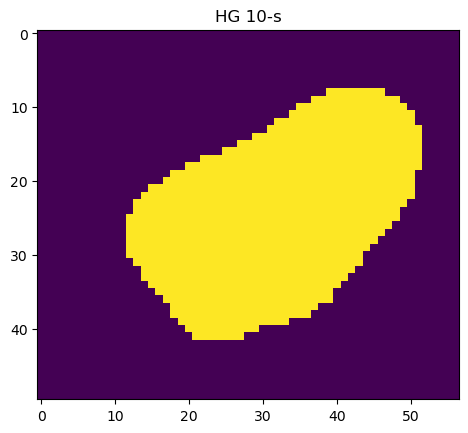

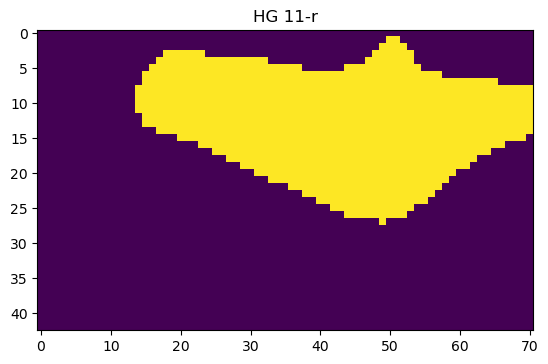

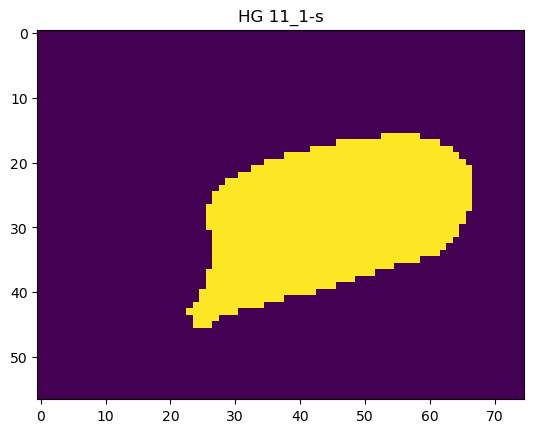

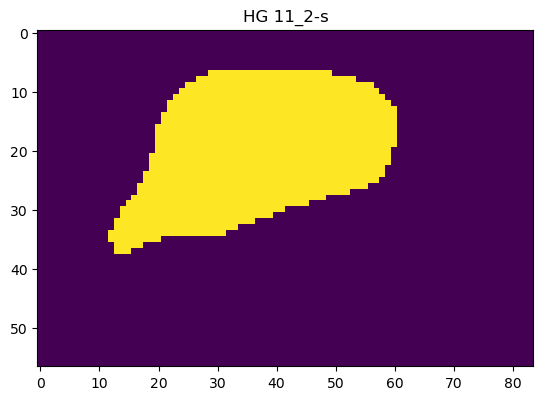

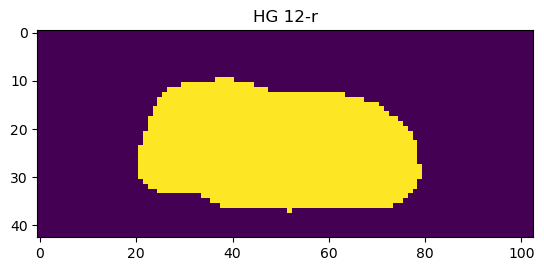

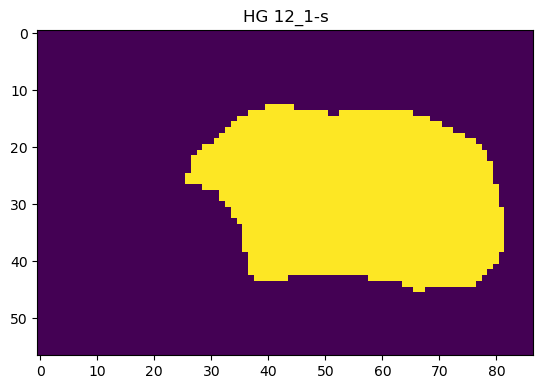

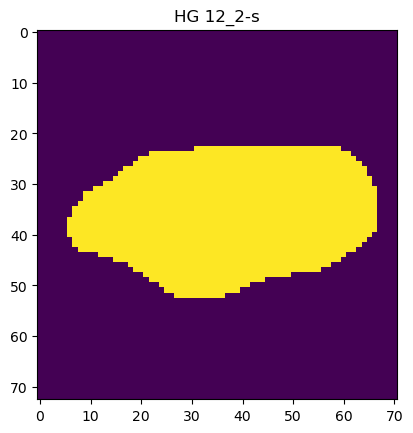

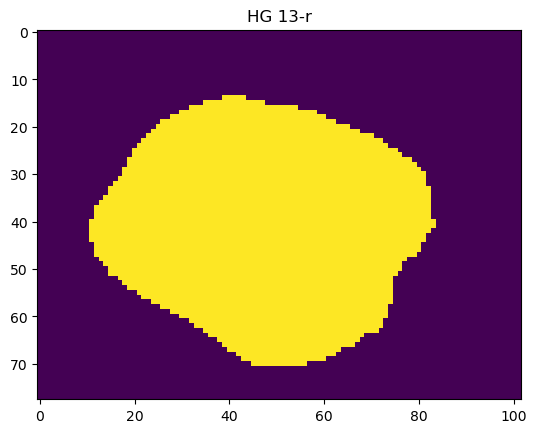

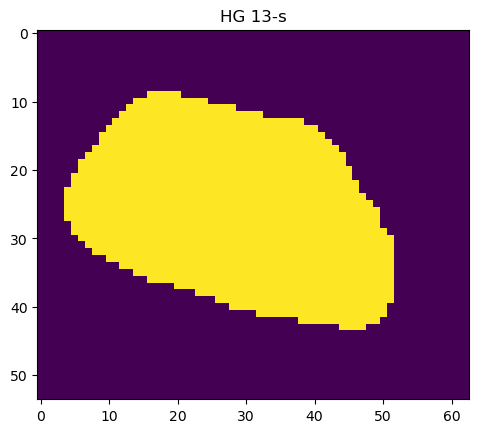

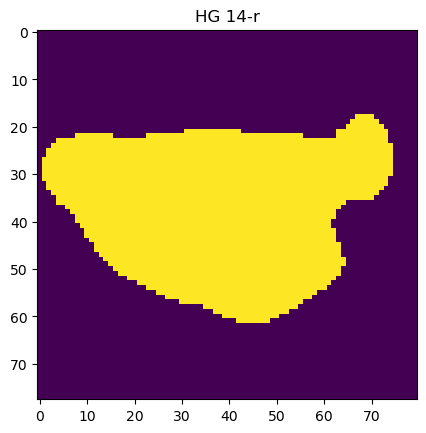

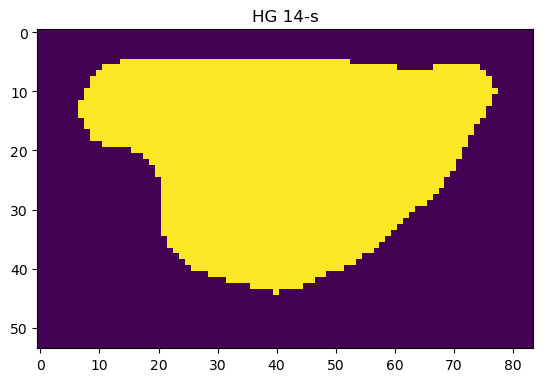

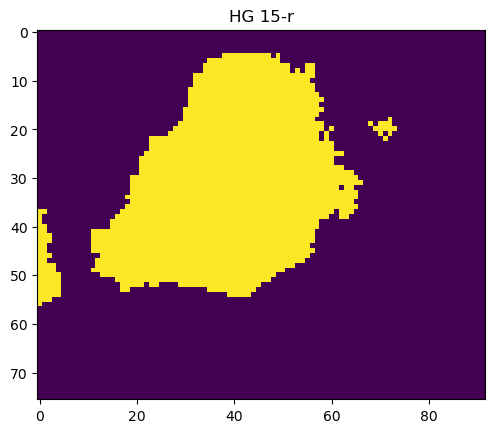

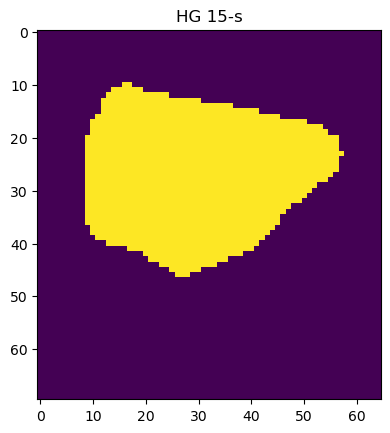

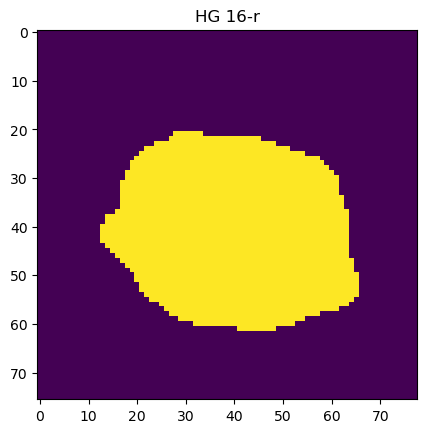

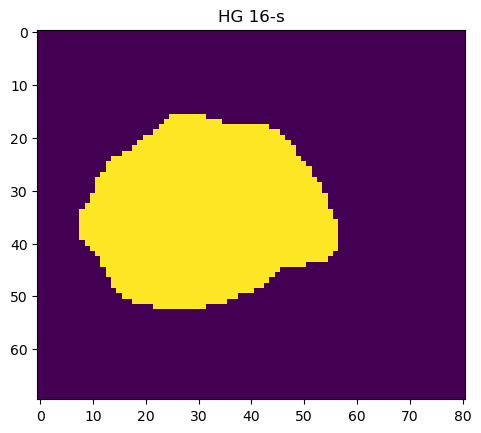

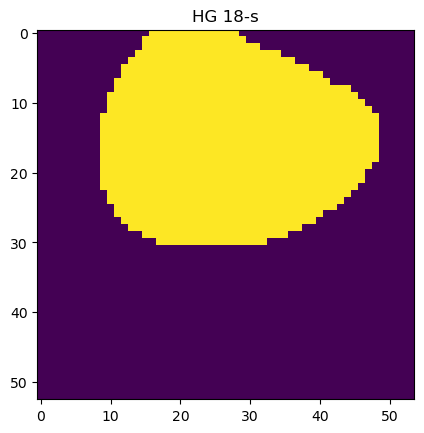

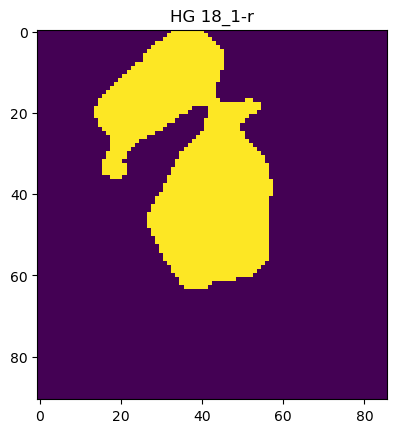

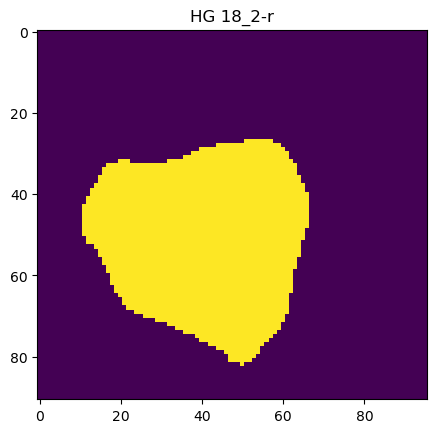

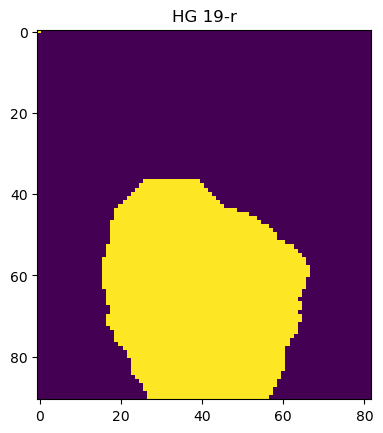

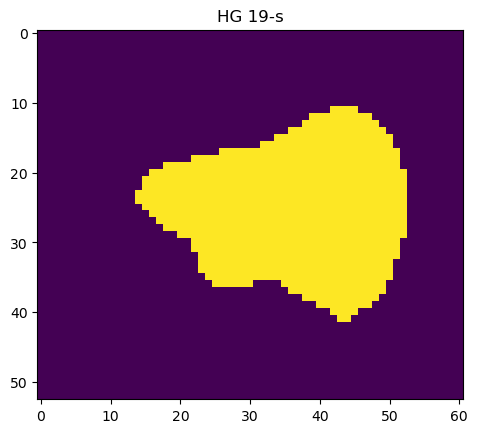

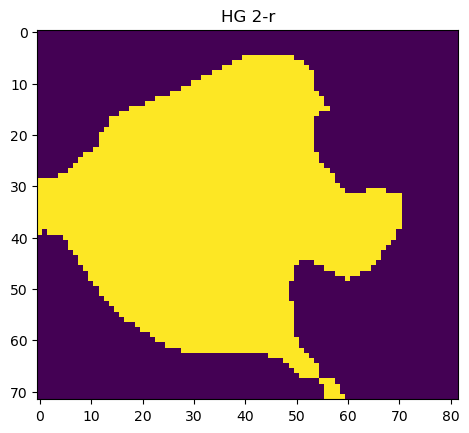

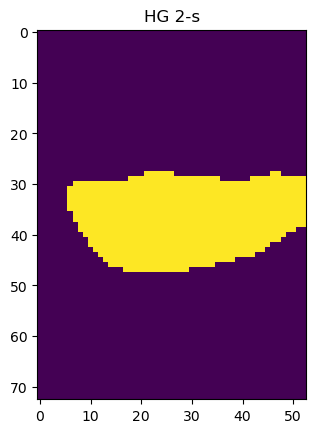

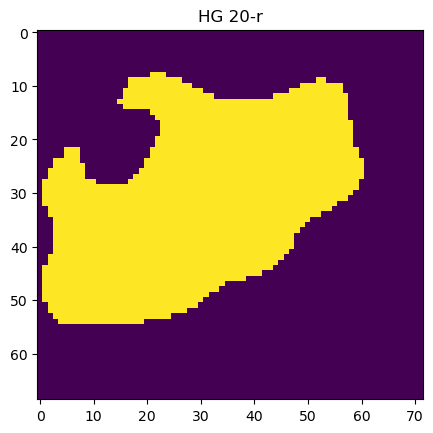

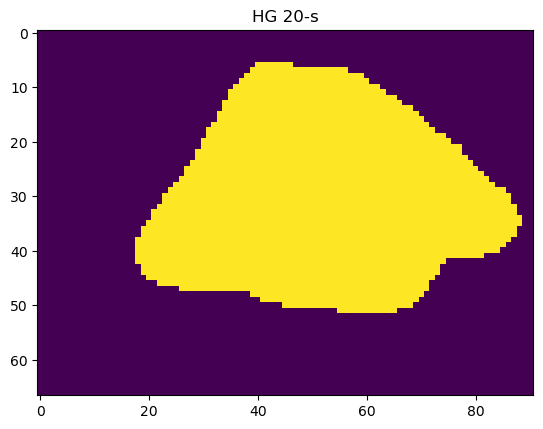

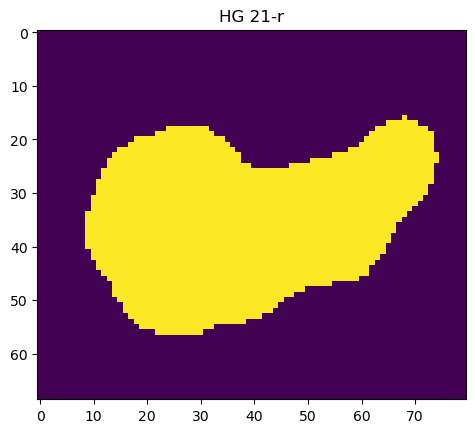

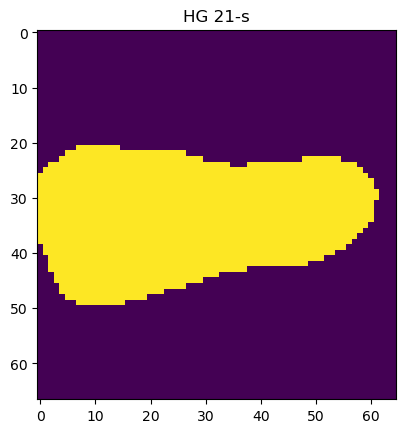

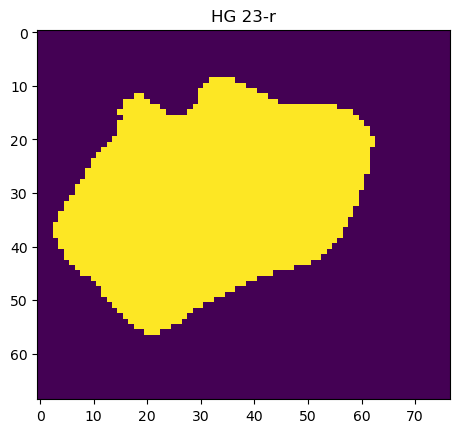

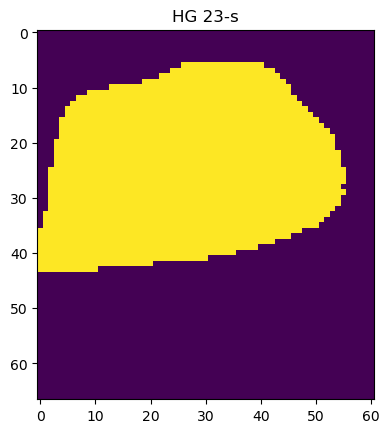

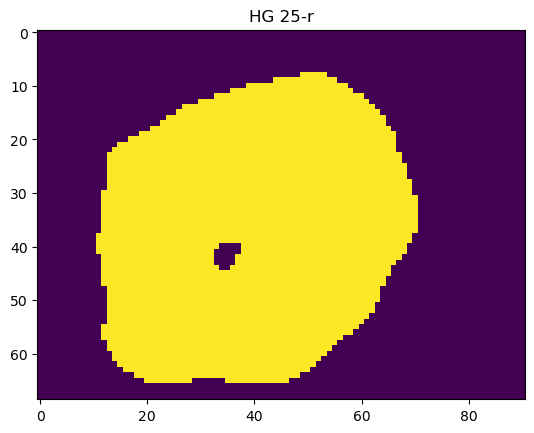

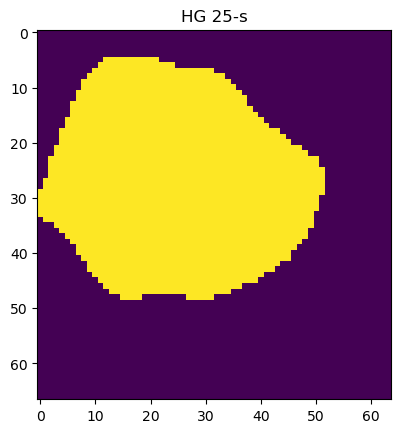

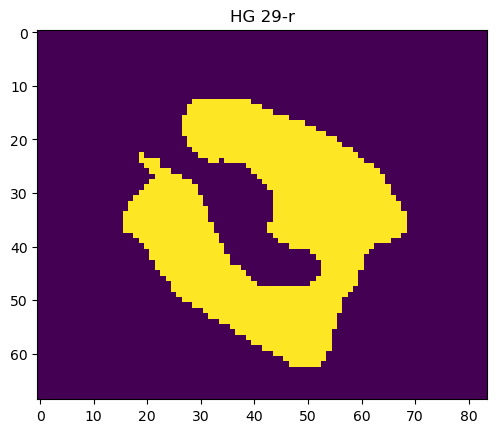

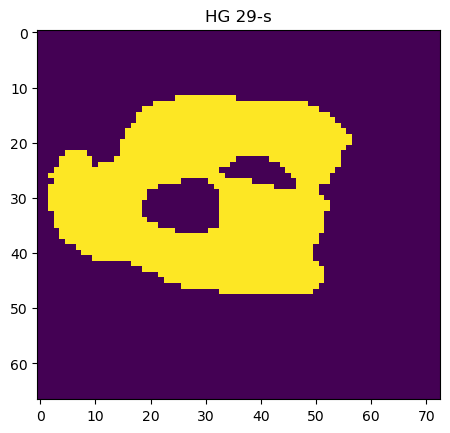

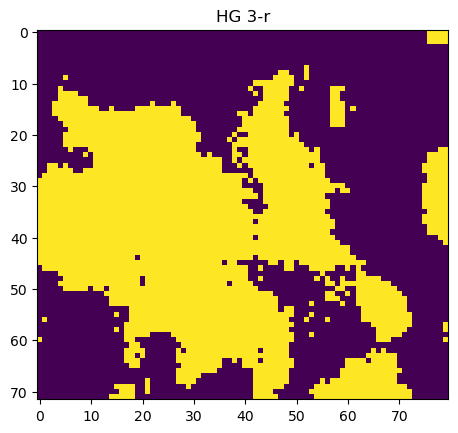

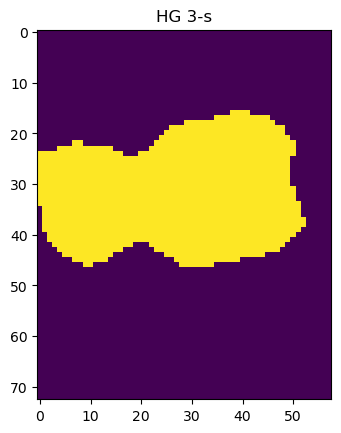

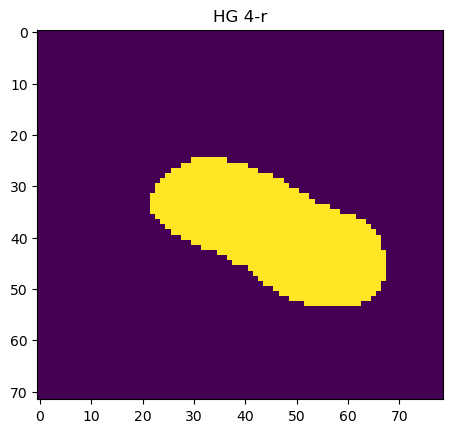

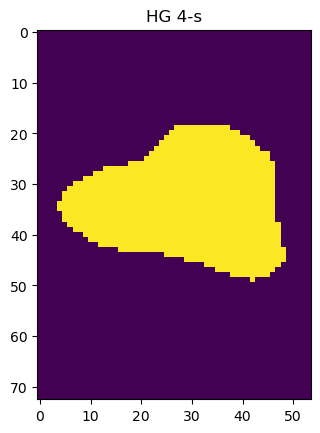

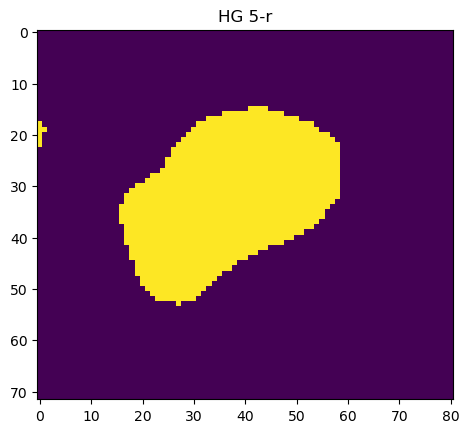

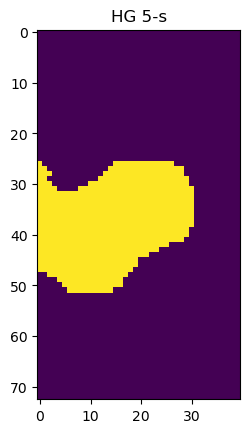

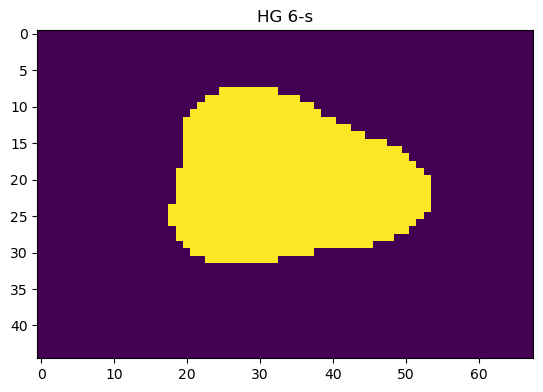

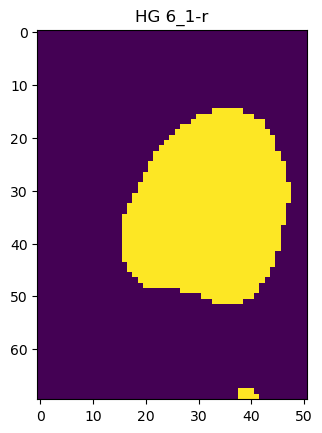

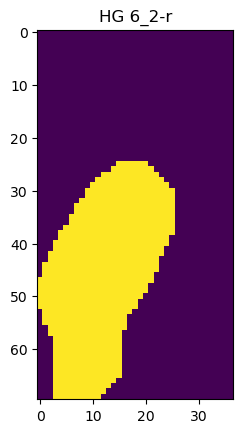

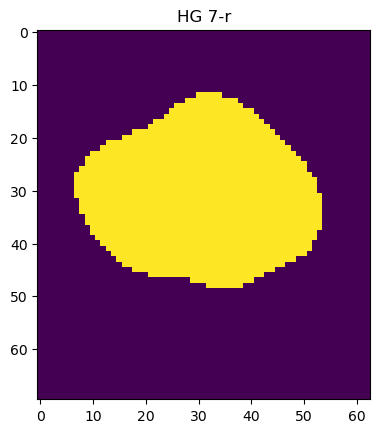

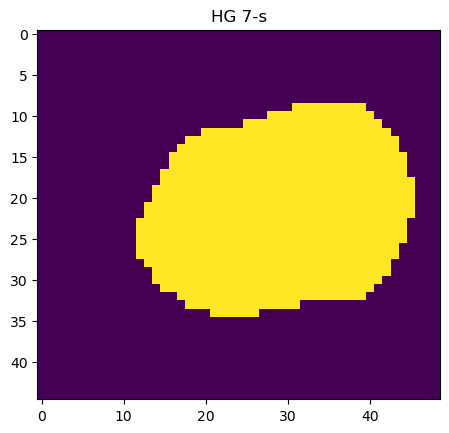

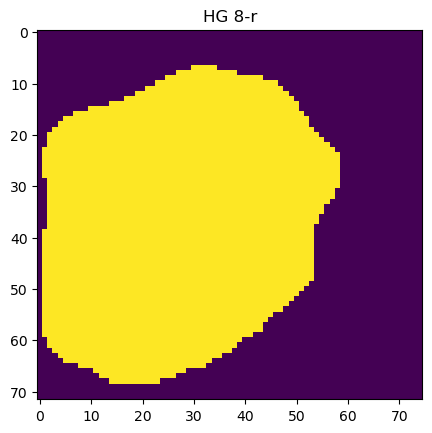

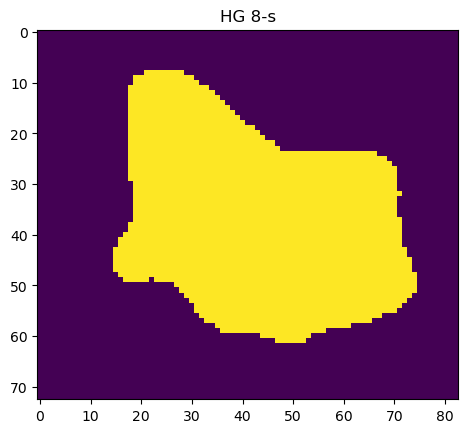

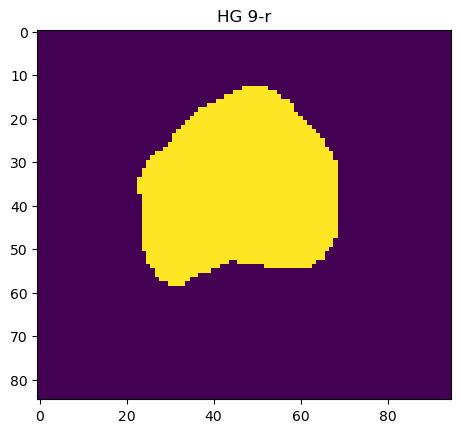

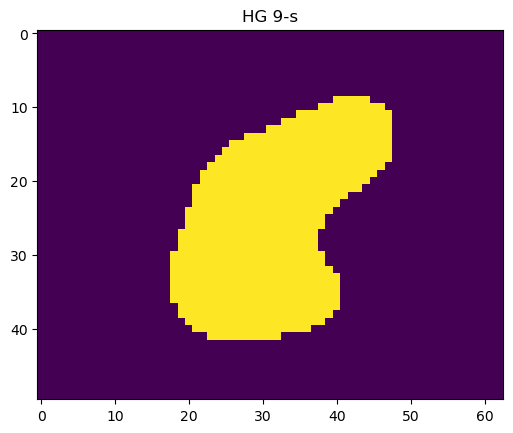

In [7]:
for f in PROCESSED_DATA.iterdir():
  plt.imshow()
  plt.title(f.name)
  plt.show()

In [ ]:
def get_mean_spectra(imzml_file: Path):
  with ImzMLParser(imzml_file) as p:
    # Initialize a dictionary to store the sum of all spectra
    sum_spectra = {}
    count = 0

    # Iterate over all spectra in the file
    for idx, (x, y, z) in enumerate(tqdm(p.coordinates)):
      mzs, intensities = p.getspectrum(idx)
      # Aggregate spectra by adding intensities at each m/z
      for m, i in zip(mzs, intensities):
        if m in sum_spectra:
          sum_spectra[m] += i
        else:
          sum_spectra[m] = i
      count += 1

    # Calculate the mean spectrum
    mean_spectrum = {m: i / count for m, i in sum_spectra.items()}

    # Convert the mean spectrum to sorted lists of m/z and intensities
    mzs, intensities = zip(*sorted(mean_spectrum.items()))

    return np.asarray(mzs), np.asarray(intensities)

In [ ]:
def write_aligned_msi(imzml_file: Path, diff):
  with ImzMLWriter(
      os.path.join(ALIGNED_DATA, imzml_file.name), mode="processed"
  ) as writer:
    with ImzMLParser(imzml_file) as p:
      # Iterate over all spectra in the file
      for idx, (x, y, z) in enumerate(tqdm(p.coordinates)):
        mzs, intensities = p.getspectrum(idx)
        mzs = [mz + diff for mz in mzs]
        writer.addSpectrum(mzs, intensities, (x, y, z))

In [ ]:
mass_lock_peak = 885.5498
tol = 1.0
for d in Path(RAW_DATA).iterdir():
  if 'imzml' in d.name:
    mzs, intensities = get_mean_spectra(d)
    filt = (mzs >= mass_lock_peak - tol) & (mzs <= mass_lock_peak + tol)
    max_intensity_index = np.argmax(intensities[filt])
    corresponding_mz = mzs[filt][max_intensity_index]
    mz_diff = mass_lock_peak - corresponding_mz
    #write_aligned_msi(d, mz_diff)
    print(d, mz_diff)

In [ ]:
!python esi_data_analysis.py

In [20]:
!python liver_data_analysis.py

Figure(500x500)
Figure(300x600)


In [123]:
!python chip_types_data_analysis.py

Figure(1000x600)


In [2]:
!python main.py

2024-04-19 07:08:42.902415: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/sise/assafzar-group/assafzar/leor/delta_tissue_slgc/Nondestructive Spatial Lipidomics for Glioma Classification - Tissue Similarity and Grading/SLGC-tissue-similarity-and-grading/main.py", line 57, in <module>
    process(
  File "/sise/assafzar-group/assafzar/leor/delta_tissue_slgc/Nondestructive Spatial Lipidomics for Glioma Classification - Tissue Similarity and Grading/SLGC-tissue-similarity-and-grading/processing/_process.py", line 173, in process
    aligned_representation(input_path, output_path, original_lock_mass_position,
  File "/sise/assafzar-group/assafzar/leor/delta_tissue_slgc/Nondestructive Spatial Lipidomics for Glioma Classification - Tissue Similarity and Grading/SLGC-tissue-similarity-and-grading/processing/_process.py", line 42, in aligned_representation
    lock_mass = Referenc

In [5]:
list((RAW_DATA).iterdir())

[PosixPath('../data/CHIP_TYPES_NEW/raw/20240125 4 chips tissue_Slide_A_Analyte 1_1.ibd'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Porous flat_Slide_A_Analyte 1_1.imzML'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Porous flat_Slide_A_Analyte 1_1.ibd'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Porous porous sub_Slide_A_Analyte 1_1.imzML'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Porous porous sub_Slide_A_Analyte 1_1.ibd'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Porous_Slide_A_Analyte 1_1.imzML'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Porous_Slide_A_Analyte 1_1.ibd'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Solid_Slide_A_Analyte 1_1.imzML'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240126 4 chips_Solid_Slide_A_Analyte 1_1.ibd'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240128 4chips_porous_Slide_A_Analyte 1_1.imzML'),
 PosixPath('../data/CHIP_TYPES_NEW/raw/20240128 4chips_porous

In [12]:
#msi_p = RAW_DATA / "20240126 4 chips_Porous flat_Slide_A_Analyte 1_1.imzML"
#msi_p = PROCESSED_DATA / "1_flat_porous_substrate-r" / "common_representation.imzML"
msi_p = PROCESSED_DATA / "1_flat_porous_substrate-r" / "meaningful_signal.imzML"
vals = []
with ImzMLParser(msi_p) as p:
  for idx, (x, y, z) in enumerate(tqdm(p.coordinates)):
    mzs, intensities = p.getspectrum(idx)
    vals.append((intensities.min(), intensities.max(), (x, y, z)))
print(np.min([x[0] for x in vals]))
print(np.max([x[1] for x in vals]))

  0%|          | 0/5852 [00:00<?, ?it/s]

-3.6235561
775.6543


In [21]:
import pandas as pd

#msi_p = RAW_DATA / "20240126 4 chips_Porous flat_Slide_A_Analyte 1_1.imzML"
msi_p = PROCESSED_DATA / "1_flat_porous_substrate-r" / "common_representation.imzML"
#msi_p = PROCESSED_DATA / "1_flat_porous_substrate-r" / "meaningful_signal.imzML"

vals = []
with ImzMLParser(msi_p) as p:
  for idx, (x, y, z) in enumerate(tqdm(p.coordinates)):
    mzs, intensities = p.getspectrum(idx)
    vals.append((intensities))

#df = pd.DataFrame(vals, columns=mzs)

  0%|          | 0/5852 [00:00<?, ?it/s]

  0%|          | 0/5852 [00:00<?, ?it/s]

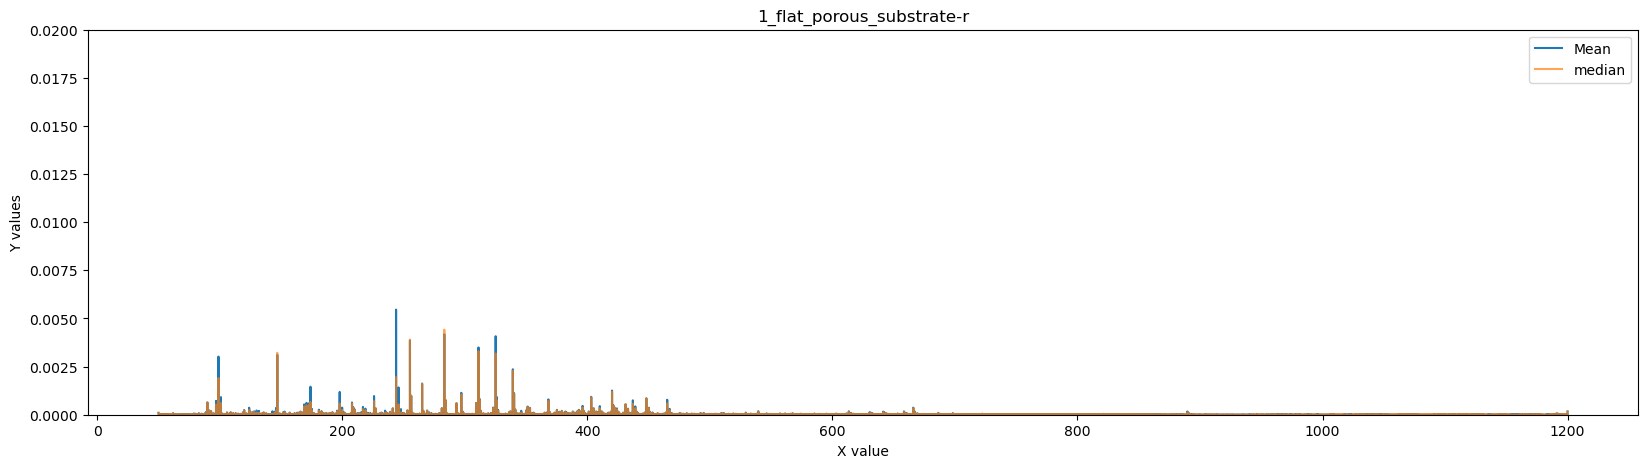

  0%|          | 0/5776 [00:00<?, ?it/s]

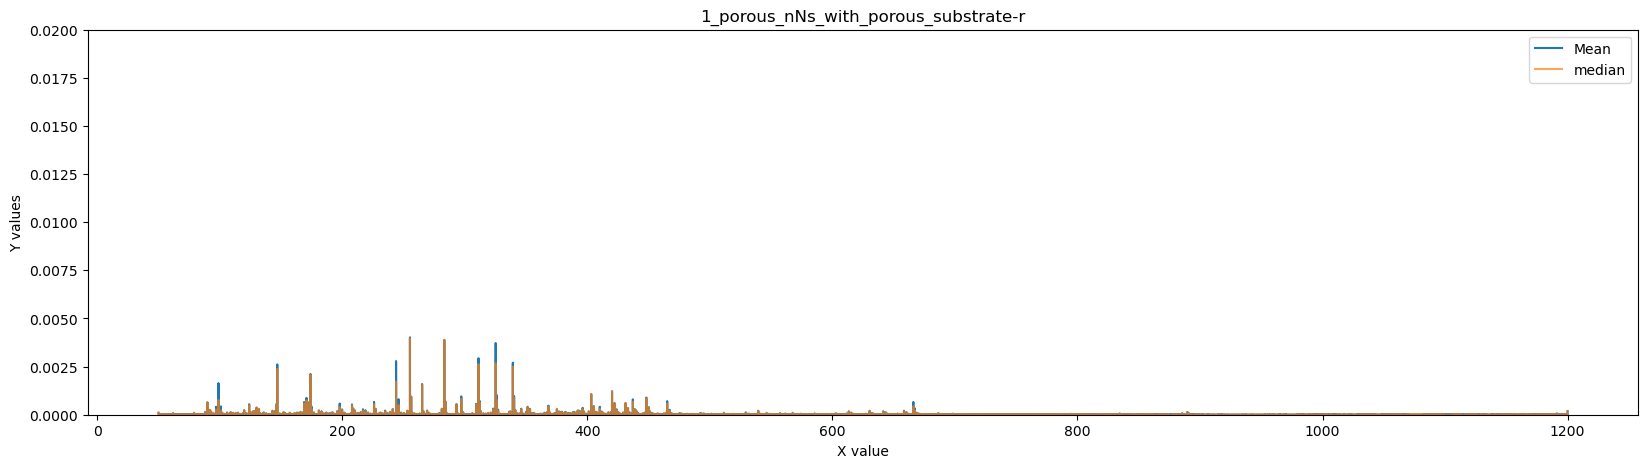

  0%|          | 0/6237 [00:00<?, ?it/s]

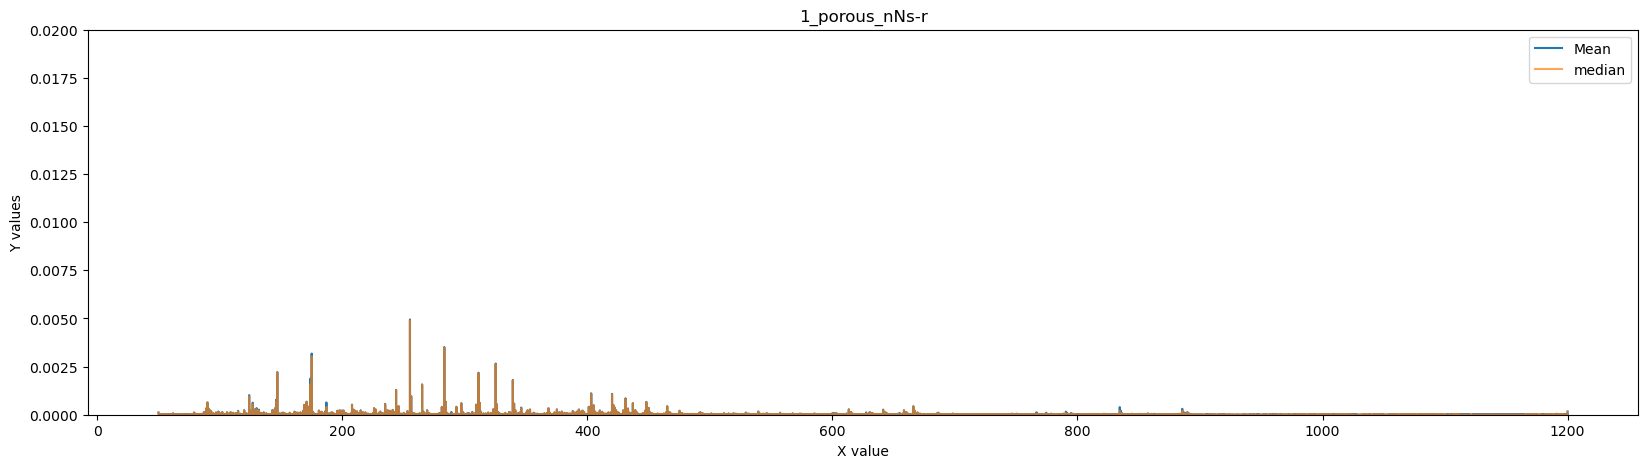

  0%|          | 0/6320 [00:00<?, ?it/s]

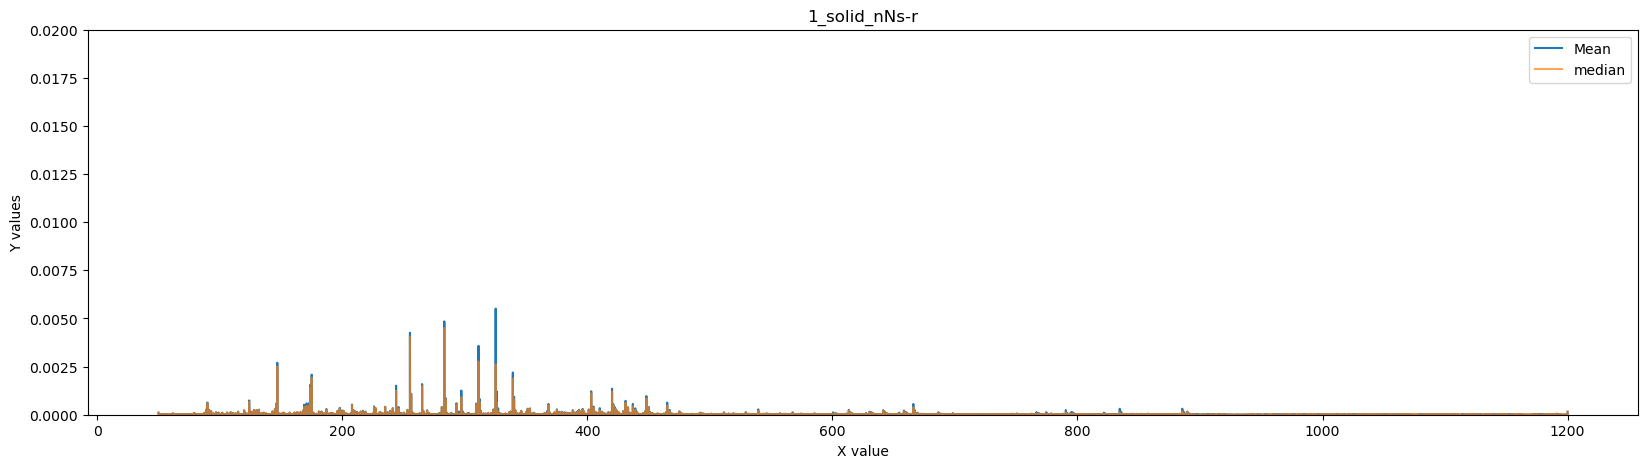

  0%|          | 0/6162 [00:00<?, ?it/s]

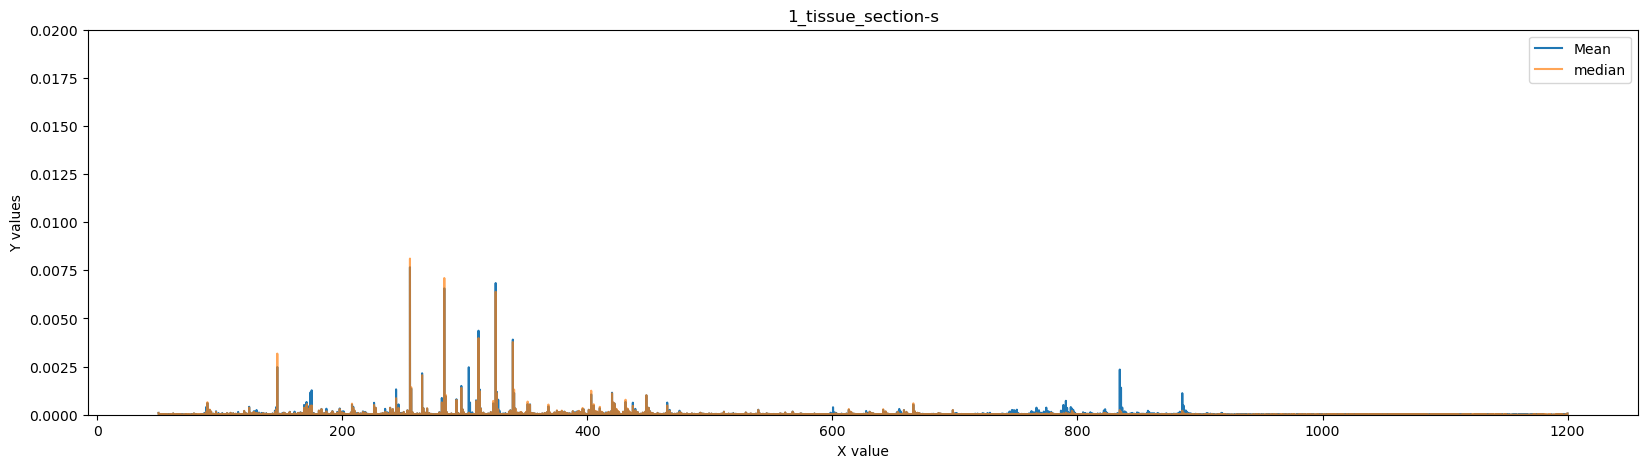

  0%|          | 0/5751 [00:00<?, ?it/s]

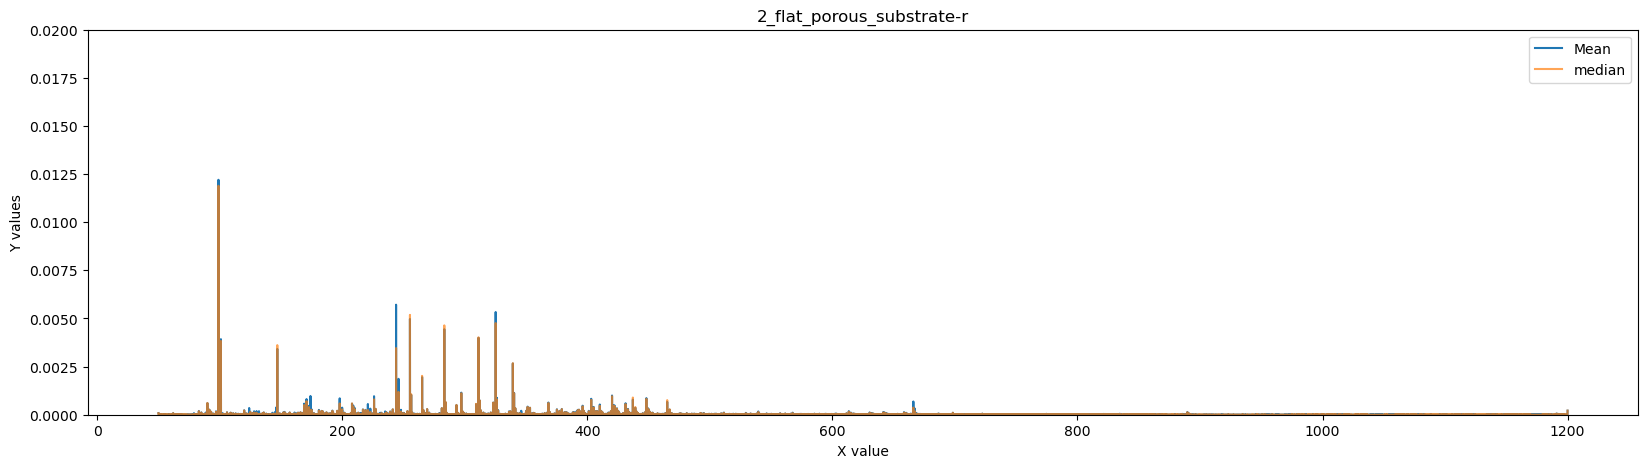

  0%|          | 0/5846 [00:00<?, ?it/s]

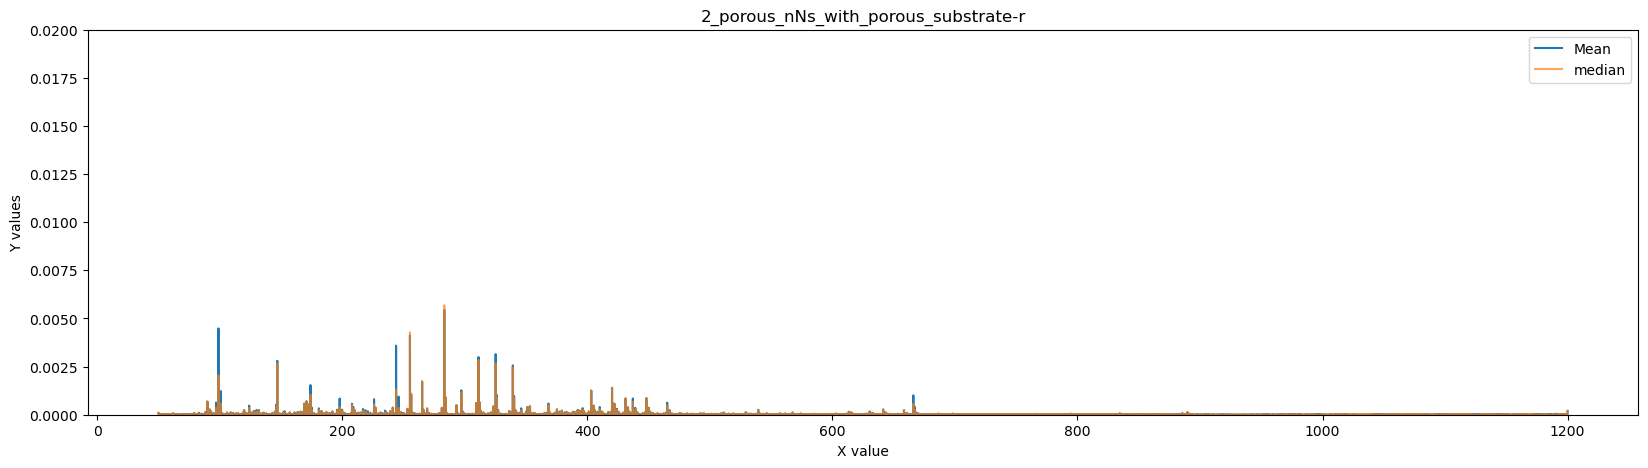

  0%|          | 0/5929 [00:00<?, ?it/s]

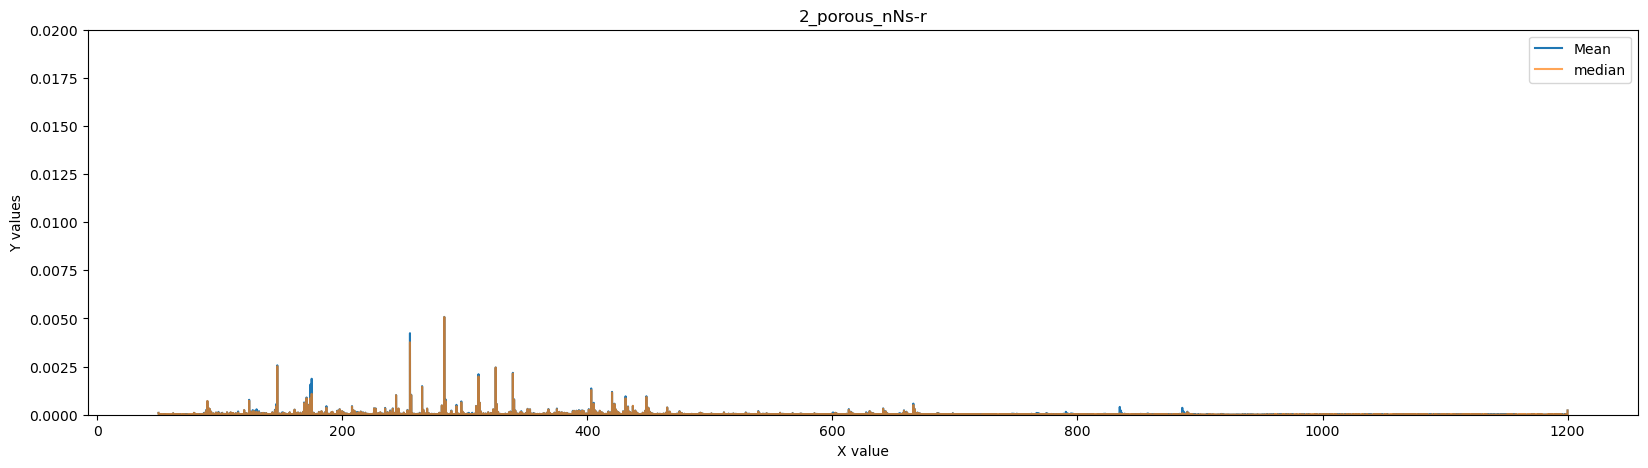

  0%|          | 0/5183 [00:00<?, ?it/s]

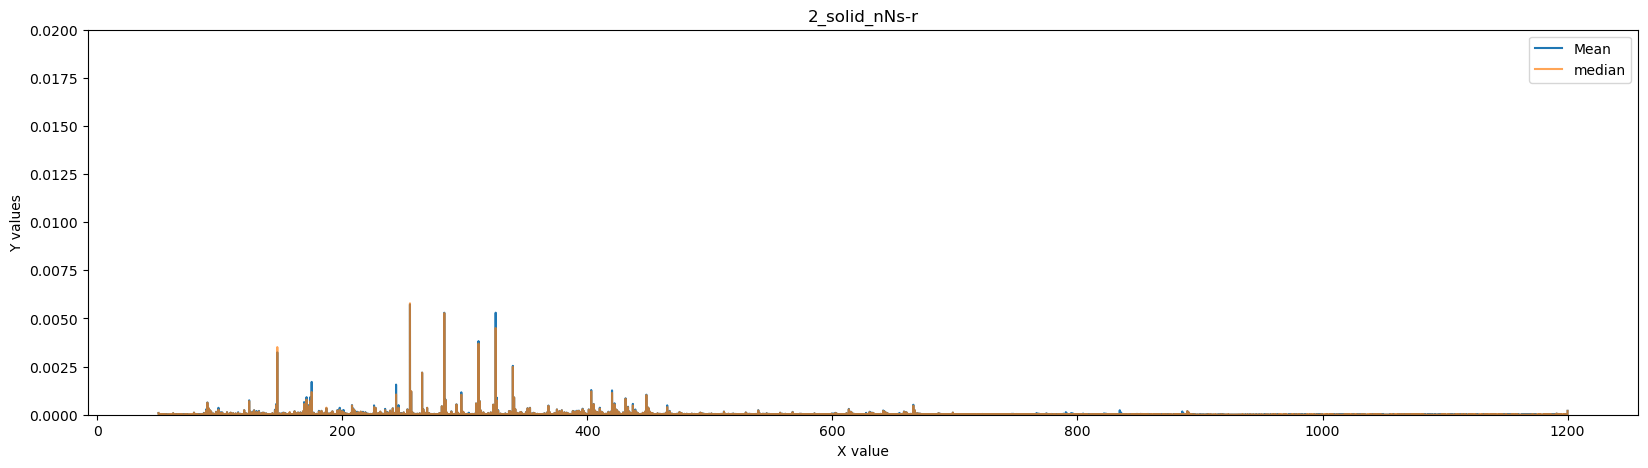

  0%|          | 0/5658 [00:00<?, ?it/s]

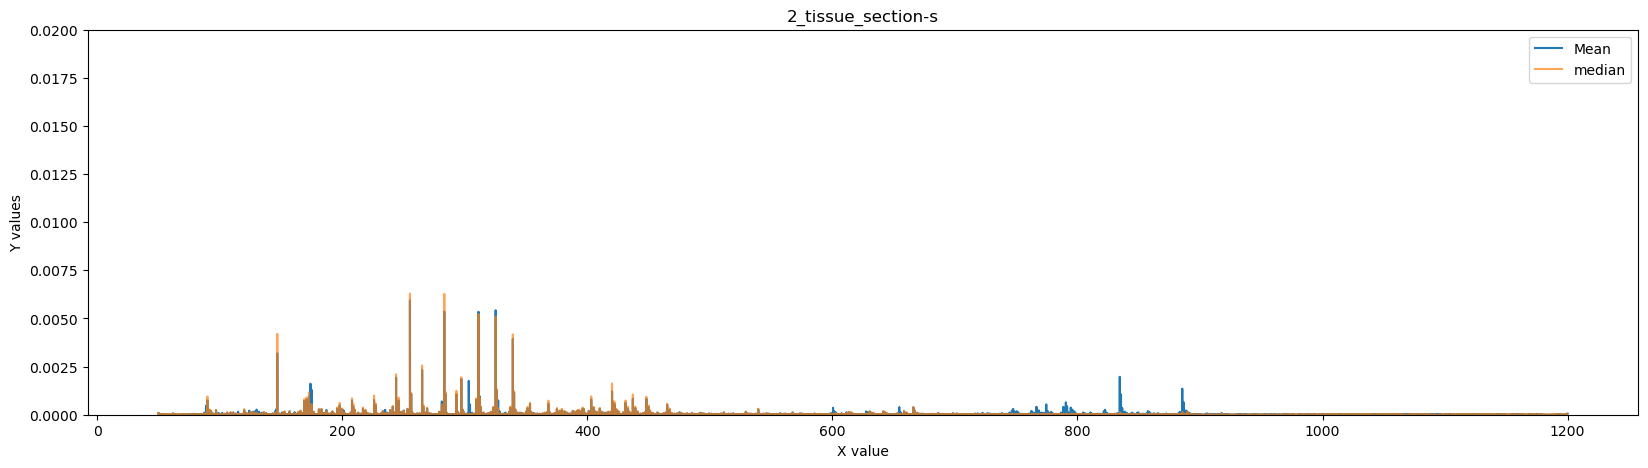

  0%|          | 0/6640 [00:00<?, ?it/s]

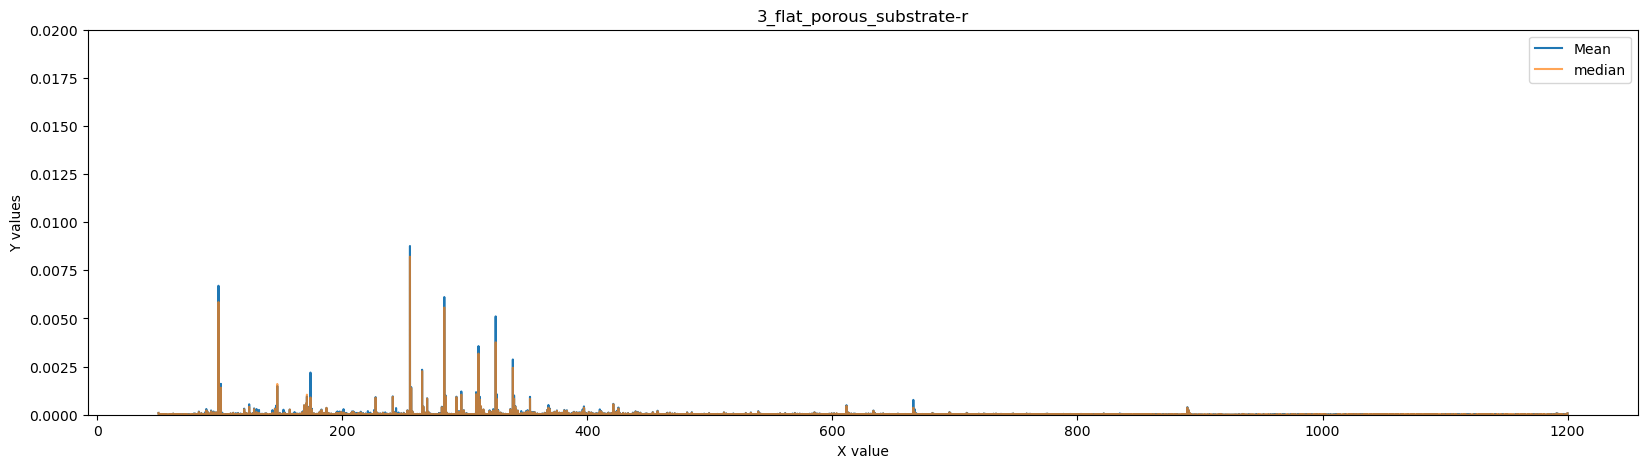

  0%|          | 0/6561 [00:00<?, ?it/s]

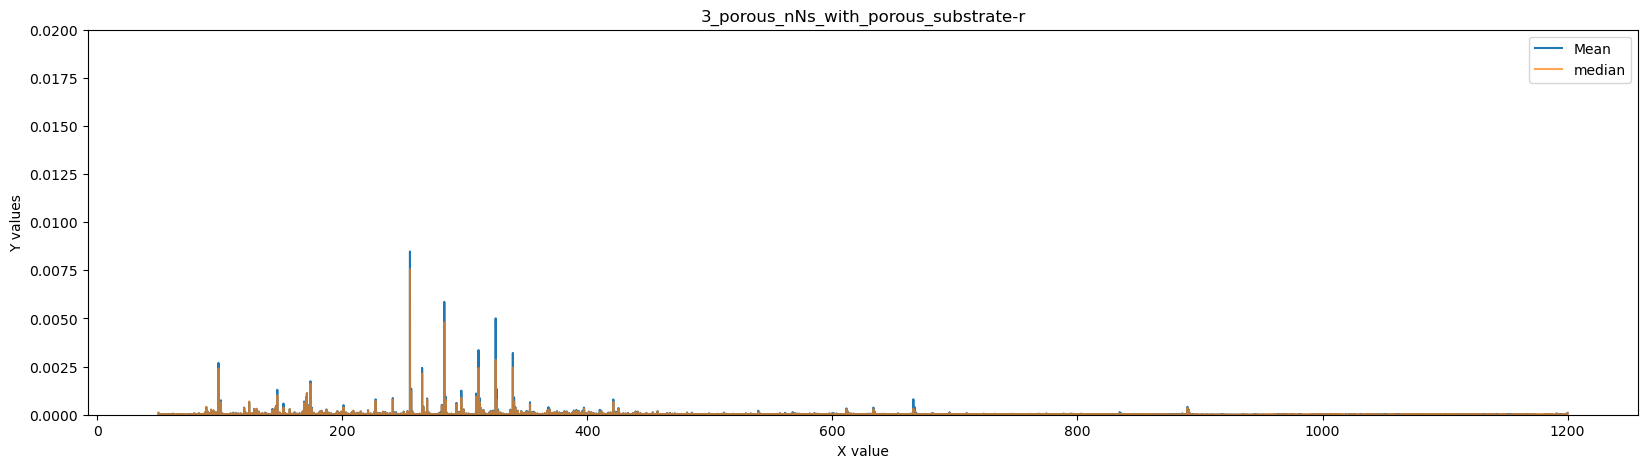

  0%|          | 0/5928 [00:00<?, ?it/s]

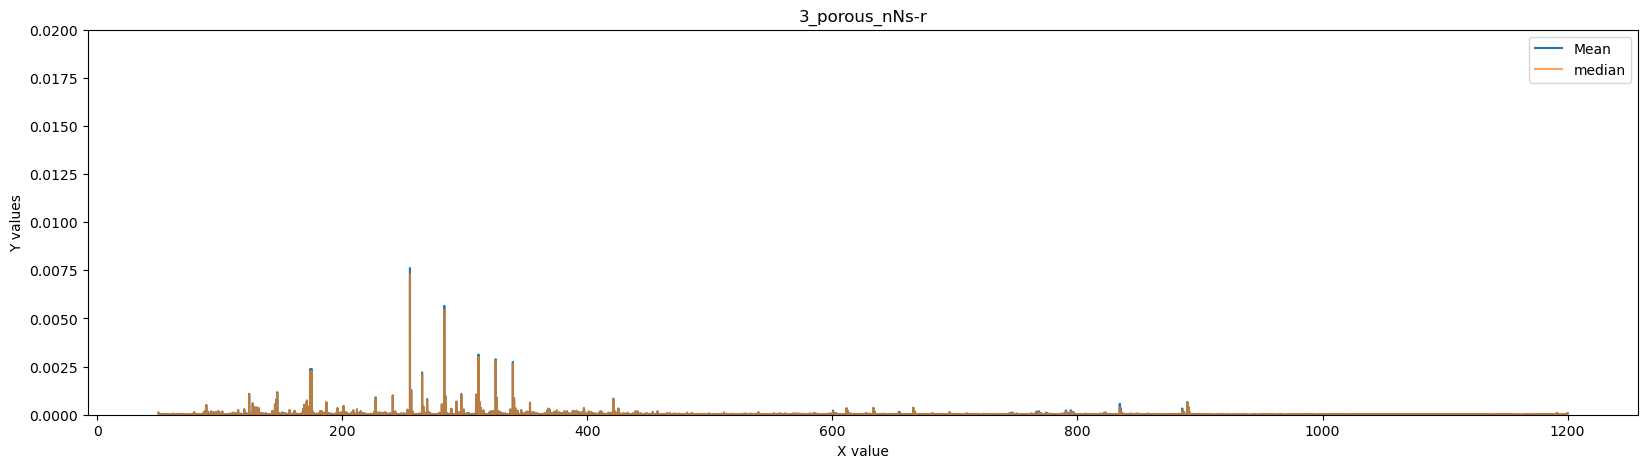

  0%|          | 0/5700 [00:00<?, ?it/s]

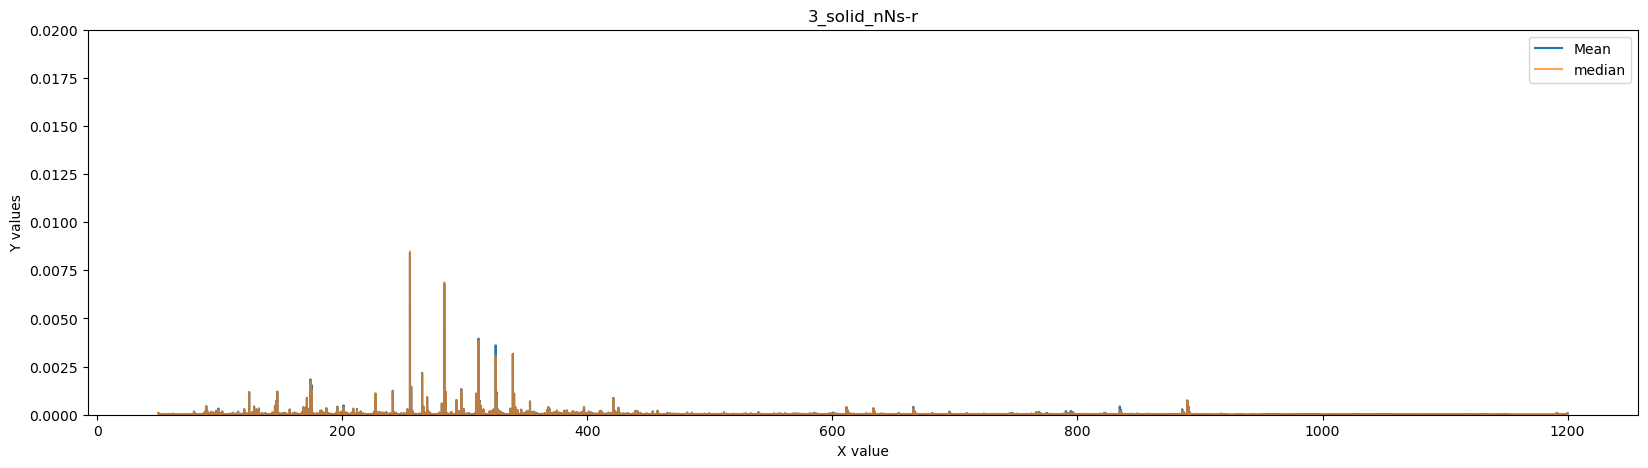

  0%|          | 0/6000 [00:00<?, ?it/s]

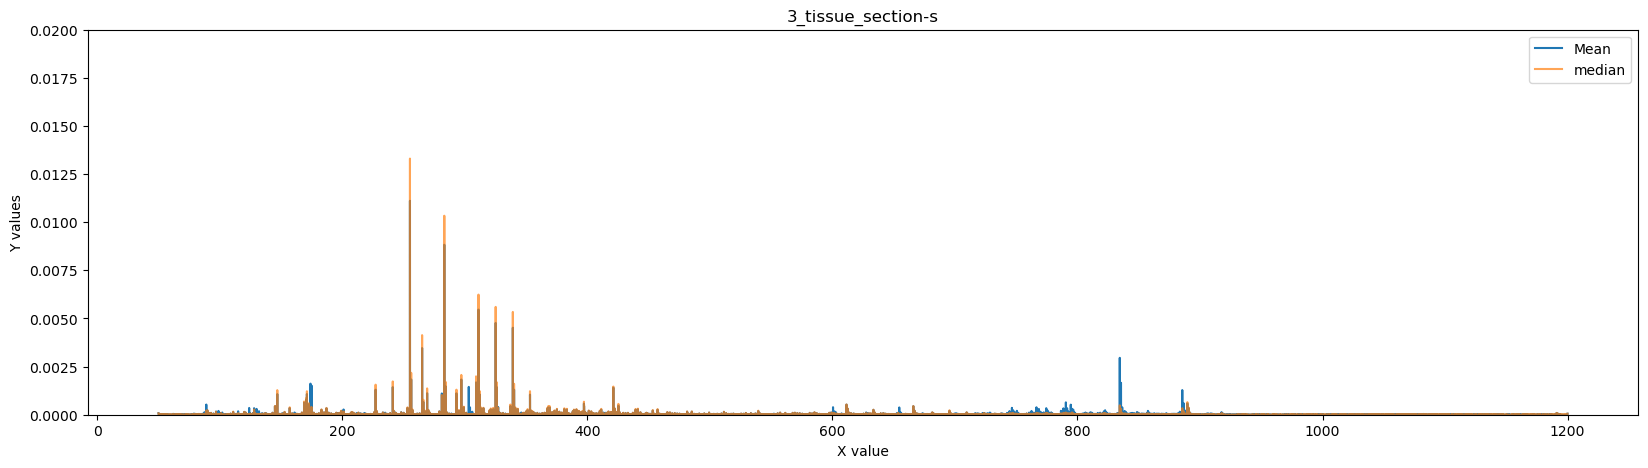

In [41]:
for folder in PROCESSED_DATA.iterdir():
  msi_p = folder / "common_representation.imzML"
  vals = []
  with ImzMLParser(msi_p) as p:
    for idx, (x, y, z) in enumerate(tqdm(p.coordinates)):
      mzs, intensities = p.getspectrum(idx)
      vals.append((intensities))
  mean = np.mean(vals, axis=0)
  median = np.median(vals, axis=0)
  std = np.std(vals, axis=0)

  plt.figure(figsize=(20, 5))

  # Plotting the mean line
  plt.plot(mzs, mean, label='Mean')
  plt.plot(mzs, median, label='median', alpha=0.7)

  # Filling the area between the confidence intervals
  #plt.fill_between(mzs, mean - std, mean + std, color='blue', alpha=0.2)

  plt.ylim(0, .02)

  plt.xlabel('X value')
  plt.ylabel('Y values')
  plt.title(msi_p.parent.name)
  plt.legend()
  plt.show()

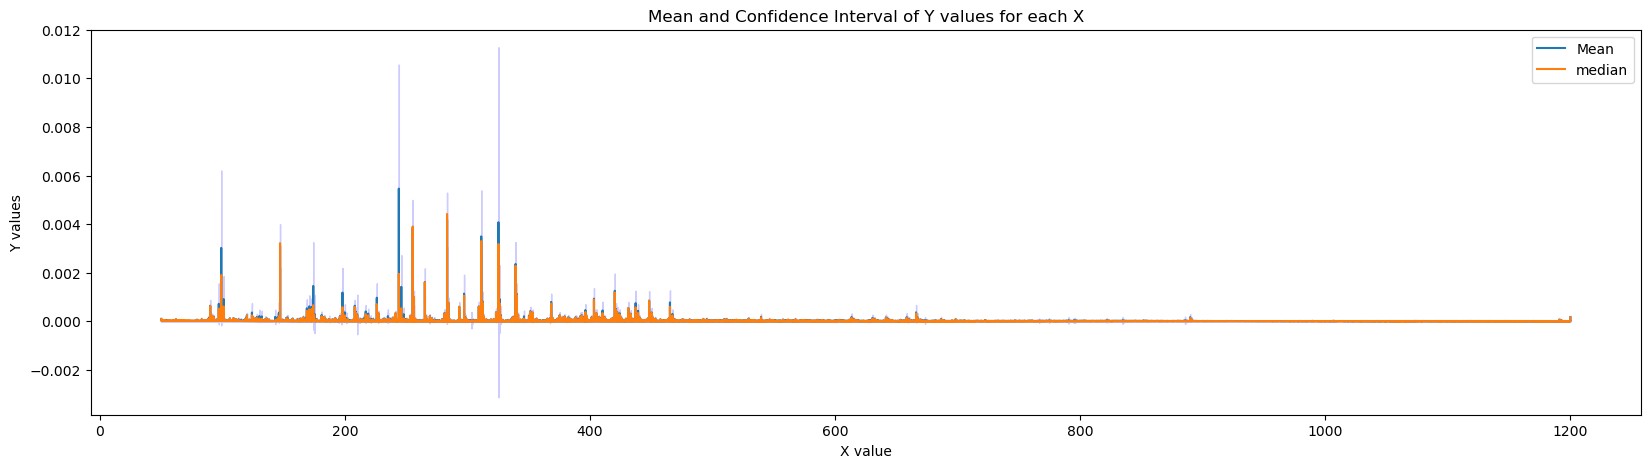

In [31]:
from matplotlib import pyplot as plt

mean = np.mean(vals, axis=0)
median = np.median(vals, axis=0)
std = np.std(vals, axis=0)

plt.figure(figsize=(20, 5))

# Plotting the mean line
plt.plot(mzs, mean, label='Mean')
plt.plot(mzs, median, label='median')

# Filling the area between the confidence intervals
plt.fill_between(mzs, mean - std, mean + std, color='blue', alpha=0.2)

plt.xlabel('X value')
plt.ylabel('Y values')
plt.title('Mean and Confidence Interval of Y values for each X')
plt.legend()
plt.show()


In [20]:
df

50.00625    50.01875    50.03125    50.04375    50.05625    50.06875    \
0      -2.231429   -1.419301    6.748225   -1.343284   -1.015310   -1.523154   
1      -2.231429   -1.419301   -1.497887   -1.343284   -1.015310   -1.523154   
2      -2.231429   -1.419301   -1.497887   -1.343284   -1.015310   -1.523154   
3       0.106857   -1.419301   -1.497887    3.888274   -1.015310   -1.523154   
4       1.171074   -1.419301   -1.497887    2.491509   -1.015310   -0.358452   
...          ...         ...         ...         ...         ...         ...   
5847   -0.462696    0.127405   -0.130720   -0.064580    0.124147    0.956030   
5848    0.041308   -0.465659   -0.739546   -0.178322   -0.338929   -1.184949   
5849    0.006185   -0.572945    0.005907   -0.926158   -0.646630   -0.504767   
5850   -1.204191   -1.391611    0.526203   -0.190964    0.117615   -0.095699   
5851   -0.841110   -1.020802   -0.966603   -1.343284   -0.298918    0.288341   

      50.08125    50.09375    50.10625    50.11875    ...  1199.88125  \
0       7.871659   -1.477272   -1.181949   -1.365820  ...   -0.933975   
1      -1.436303   -1.477272   -1.181949   -1.365820  ...   -0.933975   
2      -1.436303   -1.477272   -1.181949   -1.365820  ...   -0.933975   
3      -0.246229   -0.752914    0.469342    0.875737  ...   -0.933975   
4       0.167389   -1.477272   -1.181949   -1.365820  ...   -0.933975   
...          ...         ...         ...         ...  ...         ...   
5847   -0.382992    0.520571   -0.360344   -0.129339  ...   -0.696368   
5848   -0.481066   -0.939976    0.244343   -1.365820  ...   -0.537832   
5849    0.357643   -0.689434    0.042785   -0.200287  ...   -0.552091   
5850   -0.707838   -0.272583   -0.525230    0.666435  ...   -0.933975   
5851   -1.436303   -0.682666   -0.695082   -0.341261  ...    1.505407   

      1199.89375  1199.90625  1199.91875  1199.93125  1199.94375  1199.95625  \
0      -1.000271   -0.902806   -0.765733   -0.985084   -0.943006   -1.047551   
1      -1.000271   -0.902806   -0.765733   -0.985084   -0.943006   -1.047551   
2      -1.000271   -0.902806   -0.765733   -0.985084   -0.943006   -1.047551   
3      -1.000271   -0.902806   -0.765733   -0.985084   -0.943006   -1.047551   
4       6.876398   -0.902806   -0.765733   -0.985084   -0.943006   -1.047551   
...          ...         ...         ...         ...         ...         ...   
5847   -0.014096   -0.727058    0.135243    1.835058    0.414304   -0.265948   
5848    0.297758   -0.081027   -0.765733   -0.706307   -0.376755   -0.303805   
5849   -0.146203   -0.310974    1.274193    0.616599   -0.409816    0.169460   
5850   -1.000271   -0.056106    1.147197   -0.346664   -0.564639    1.024979   
5851    0.280000   -0.152961    0.735864    0.410071    0.626477   -0.724136   

      1199.96875  1199.98125  1199.99375  
0      -0.832149   -1.064246   -3.050096  
1      -0.832149   -1.064246   -3.050096  
2      -0.832149   -1.064246   -3.050096  
3       0.981467    2.057349    2.784438  
4      -0.832149   -1.064246   -0.950294  
...          ...         ...         ...  
5847   -0.425198    1.696329   -0.414551  
5848    1.455436   -0.637871   -0.143762  
5849    0.379067    0.764724    0.372382  
5850    2.058419    0.793518    0.456967  
5851    1.820515   -1.064246    0.473699  

[5852 rows x 92000 columns]

In [16]:
a = np.asarray([0.004, 0.07, 0.008, 0.12])
a.mean()
a.std()
(a - a.mean()) / a.std()

array([-0.97070052,  0.40706796, -0.8871994 ,  1.45083196])

1.0


In [32]:
with ImzMLParser(
    PROCESSED_DATA / "1_flat_porous_substrate-r" / "meaningful_signal.imzML"
) as p:
  for idx, (x, y, z) in enumerate(tqdm(p.coordinates)):
    mzs, intensities = p.getspectrum(idx)
    print(intensities.min())

  0%|          | 0/5852 [00:00<?, ?it/s]

-3.2479596
-3.6235561
-3.588407
-2.734763
-2.7770107
-2.279745
-2.3877509
-2.5008037
-2.2255864
-2.3771002
-2.2196717
-2.3877509
-2.29316
-2.2314289
-2.4480827
-2.0681248
-2.3779767
-2.9325259
-2.7203546
-2.5344431
-2.7770107
-2.7087693
-2.5871105
-2.4311805
-2.3877509
-2.3941166
-2.4053862
-3.0500963
-2.705724
-2.3255255
-2.5154757
-2.2009175
-2.2995489
-2.279745
-2.358636
-2.2255864
-2.3680174
-2.4185107
-2.256565
-2.279745
-2.279745
-2.359115
-2.6137996
-2.453066
-2.7345998
-2.638755
-2.33092
-3.0500963
-2.279745
-2.4286377
-2.2430556
-2.256565
-2.3705618
-2.638755
-2.4226127
-2.9325259
-3.0500963
-2.4186287
-2.4424021
-2.790575
-2.7770107
-2.4424021
-2.9857333
-2.5098724
-2.531611
-2.4548326
-2.6223204
-2.2619872
-2.6223204
-2.1244059
-2.7770107
-3.0500963
-2.1811826
-2.1324954
-2.3941166
-2.5997694
-3.0500963
-3.2479596
-3.0500963
-2.3669856
-2.279745
-2.187788
-2.1633642
-2.3877509
-2.5415277
-1.9579753
-2.3149247
-2.1326096
-2.1225882
-2.2626252
-1.9809515
-2.0406468
-2.10703
-2

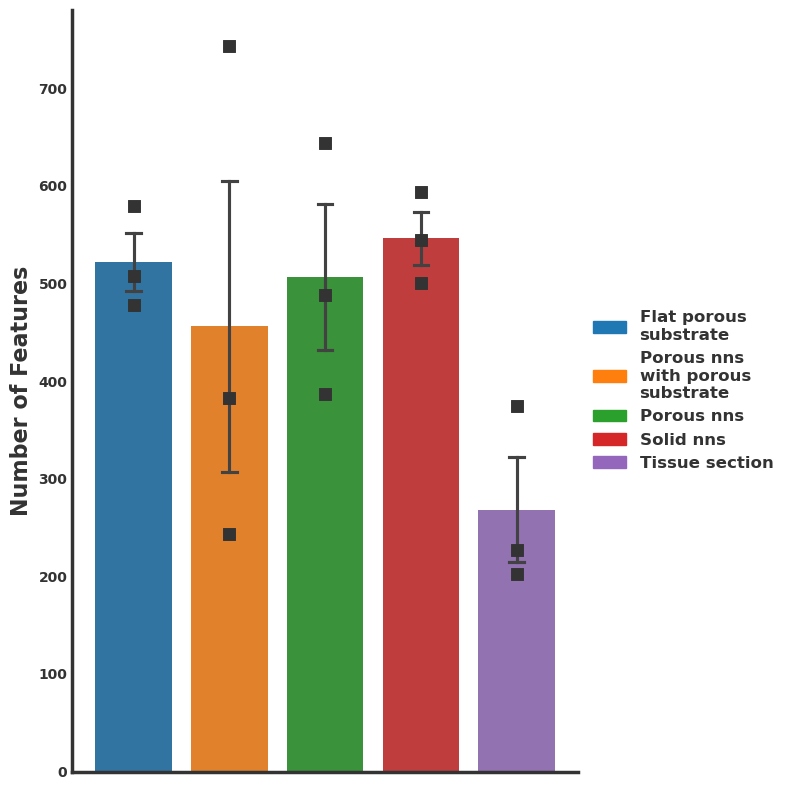

In [28]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch


def plot_num_features(
    num_features: pd.DataFrame, percentage: float, save_path: Path
):
  """Plots and saves a bar chart comparing the number of features between chip
  types in a certain percentage.

  Args:
    num_features_df (pd.DataFrame): dataframe containing the number of features
        in each percentage threshold for each parser.
    percentage (float): percentage to get number of features. (should be in the
        already calculated percentages)
    save_path (Path): Path object where the output image will be saved.
  """
  # Get number of features for corresponding peakP percentage
  num_features = num_features[num_features["Peak Percentage"] == percentage]
  # Now we plot the bars for the mean and add error bars for the SEM.
  _, ax = plt.subplots(1, 1, figsize=(8, 8))
  # create color palette
  palette_dict = {
      label: color for label, color in
      zip(num_features['Type'].unique(), sns.color_palette())
  }
  # Create a bar plot using seaborn with custom error bars
  ax = sns.barplot(
      data=num_features, x="Type", y="Number of Features", hue="Type",
      errorbar=lambda x: (x.mean() - x.sem(), x.mean() + x.sem()), capsize=0.15,
      palette=palette_dict
  )
  sns.scatterplot(
      data=num_features, x="Type", y="Number of Features", legend=False,
      zorder=10, color='0.2', edgecolor='0.2', marker='s', s=70
  )
  # Customize the spines
  for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  # Customize ticks
  plt.xticks(fontsize=10, fontweight='bold', color='0.2')
  plt.xticks(rotation=45)
  plt.yticks(fontsize=10, fontweight='bold', color='0.2')
  ax.set_xticklabels([])
  # Add legend to the plot with a title
  legend_patches = [
      Patch(color=color, label=label) for label, color in palette_dict.items()
  ]
  leg = ax.legend(
      loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True,
      shadow=True, handles=legend_patches, prop={"size": 12}
  )

  leg.set_frame_on(False)

  for line in leg.get_lines():
    line.set_linewidth(3.5)
  for text in leg.get_texts():
    text_parts = text.get_text().split("_")
    if len(text_parts) > 2:
      parts_new = []
      for i in range(0, len(text_parts), 2):
        parts_new.append(" ".join(text_parts[i:i + 2]))
      text.set_text("\n".join(parts_new).capitalize())
    else:
      text.set_text(" ".join(text_parts).capitalize())
    text.set_weight('bold')
    text.set_color('0.2')
  # Remove ticks line
  ax.tick_params(axis='both', length=0)
  # Set labels
  ax.set_ylabel('Number of Features', fontsize=16, weight='bold', color='0.2')
  ax.set_xlabel("")
  # Add space between subplots and show the plot
  plt.tight_layout()
  # Save the plot
  plt.savefig(
      save_path.joinpath("number_of_features_bar_graph.png"),
      bbox_inches='tight', dpi=1200, transparent=True
  )
  # Display the plot
  plt.show()


# Define path to save figures
PLOT_PATH = Path(".") / "chip_types"
num_features = pd.read_csv(PLOT_PATH.joinpath("num_features.csv"))
#plot_num_features_thresholds(num_features, PLOT_PATH)
plot_num_features(num_features, 0.3, PLOT_PATH)

In [2]:
from pathlib import Path
import pandas as pd

csvs = []
for csv in Path("./esi/").rglob("*.csv"):
  df = pd.read_csv(csv)
  df.insert(0, "Bin size", csv.parent.name.split("_")[-1])
  csvs.append(df)

combined = pd.concat(csvs, axis=0, ignore_index=True)
combined.to_csv("./esi/spectras_diffs_combined.csv", index=False)

In [ ]:
import os

os.listdir(
    "/sise/assafzar-group/assafzar/leor/delta_tissue_slgc/Nondestructive Spatial Lipidomics for Glioma Classification - Tissue Similarity and Grading/SLGC-tissue-similarity-and-grading/../data/ESI"
)

In [ ]:
import os
import numpy as np
from pathlib import Path
import sys

sys.path.append(".")
from esi_data_analysis import get_spectra, aggregate_spectra
from processing import EqualWidthBinning, TICNormalizer

# Define current folder using this file
CWD = "."
# Define path to data
ESI_PATH = Path(os.path.join(CWD, "..", "data", "ESI"))
# Define mass range start value
MZ_START = 50
# Define mass range end value
MZ_END = 1200
# Define mass resolution of the data
MASS_RESOLUTION = 0.5
#
LOCK_MASS_PEAK = 885.5498
#
LOCK_MASK_TOL = 1.0

# Process each mzml file in the specified directory
raw_spectras = {
    file.stem: get_spectra(file)
    for file in ESI_PATH.iterdir()
    if file.suffix.lower() == '.mzml' and 'TISSUE 3-2' not in file.name
}
# Aggregate the spectra using sum as the aggregation function
aggregated_spectras = {
    file: aggregate_spectra(spectra, np.sum)
    for file, spectra in raw_spectras.items()
}

# Apply lock mass
for name, (mzs, intensities) in aggregated_spectras.items():
  # Define filter for lock mass peak +- tol range
  mz_filter = (mzs >= LOCK_MASS_PEAK -
               LOCK_MASK_TOL) & (mzs <= LOCK_MASS_PEAK + LOCK_MASK_TOL)
  # Get max peak index in range
  max_intensity_index = np.argmax(intensities[mz_filter])
  # Get max peak mz in range
  corresponding_mz = mzs[mz_filter][max_intensity_index]
  # Get difference between lock mass peak and founded peak
  mz_diff = LOCK_MASS_PEAK - corresponding_mz
  # Apply difference to mzs
  mzs = [mz + mz_diff for mz in mzs]
  # Update spectras
  aggregated_spectras[name] = (mzs, intensities)

# Get normalizer object
normalizer = TICNormalizer()
# Get binning object
binning = EqualWidthBinning(MZ_START, MZ_END, MASS_RESOLUTION / 2)
# Create process pipe
process_pipe = (
    lambda mzs, intensities:
    (binning.bin(normalizer.normalize((mzs, intensities))))
)
# Apply process pipe
processed_spectras = {
    file: process_pipe(*spectra)
    for file, spectra in aggregated_spectras.items()
}

In [ ]:
import itertools
from typing import Dict, List
from matplotlib import pyplot as plt


def file_plot_name(file_name: str) -> str:
  """
  Generates a plot name based on a file name.

  Args:
    file_name (str): The file name to process.

  Returns:
    str: A processed string suitable for use as a plot name.

  """
  # Split the file name by spaces
  parts = file_name.split(" ")
  # Return a part of the file name depending on its length
  return " ".join(parts[3:]) if len(parts) > 4 else " ".join(parts[2:])


def plot_spectras_best_fit_scatter(
    spectras: Dict[str, Dict[float, List[float]]], save_path: Path
) -> None:
  """
    Plots the best fit line for the given spectras using scatter plot and saves the figure.

    Args:
      spectras (Dict[str, Dict[float, List[float]]]): Dictionary of spectras.
      save_path (Path): Path where the best fit plot will be saved.
    """
  # Create directory to save figures
  save_path = save_path.joinpath("best_fit_plots")
  save_path.mkdir(parents=True, exist_ok=True)

  # Loop over all combinations
  for i, j in itertools.combinations(spectras.keys(), 2):
    # Extract data
    data_i = spectras[i][1]
    data_j = spectras[j][1]

    # Create figure
    _, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

    # Calculate the range and suitable limits for the plot
    range_i = np.percentile(data_i, [0, 99])
    range_j = np.percentile(data_j, [0, 99])
    ax.set_xlim(range_j[0], range_j[1])
    ax.set_ylim(range_i[0], range_i[1])

    # Plot identity diagonal within the new limits
    ax.plot(
        [min(range_j[0], range_i[0]),
         max(range_j[1], range_i[1])],
        [min(range_j[0], range_i[0]),
         max(range_j[1], range_i[1])], linestyle='--', color='gray', linewidth=2
    )

    # Plot scatter
    ax.scatter(data_j, data_i, c='blue', alpha=0.5)

    # Customize the spines and labels
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set axis labels
    ax.set_ylabel(file_plot_name(i), fontsize=14, weight='bold', color='0.2')
    ax.set_xlabel(file_plot_name(j), fontsize=14, weight='bold', color='0.2')

    # Remove ticks line
    ax.tick_params(axis='both', which='both', length=0)
    ax.xaxis.set_tick_params(rotation=45)

    # Save the plot
    plt.savefig(
        save_path.joinpath(f"{i}_{j}_scatter.png"), bbox_inches='tight',
        dpi=300, transparent=True
    )
    # Show the plot
    plt.show()


plot_spectras_best_fit_scatter(processed_spectras, Path("./figures"))

In [ ]:
from scipy.signal import find_peaks

indexes = find_peaks(intensities)[0]
top_peak = intensities[indexes].max()
peaks = indexes[(intensities[indexes] >= (top_peak * 0.05))]

In [7]:
tics = {}
for folder in PROCESSED_DATA.iterdir():
  with ImzMLParser(folder.joinpath("common_representation.imzML")) as p:
    mzs, img = read_msi(p)
    tics[folder.stem] = img.sum(axis=(0, 1)) / img.shape[-1]

In [ ]:
mzs_count = []
mzs_filter = (mzs >= 600) & (mzs <= 900)
for name, vec in tics.items():
  vec_filtered = vec[mzs_filter]
  mzs_filtered = mzs[mzs_filter]
  mzs_count.append(mzs_filtered[vec_filtered.argsort()[-100:][::-1]])

In [8]:
mzs_filter = (mzs >= 600) & (mzs <= 900)
mzs_filtered = mzs[mzs_filter]

In [ ]:
import numpy as np

#
unique_values, counts = np.unique(
    np.array(mzs_count).ravel(), return_counts=True
)

# Get the indices that would sort the counts array
sorted_indices = np.argsort(counts)

# Use the sorted indices to sort the unique values and their counts
sorted_unique_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

# If you want to sort them in descending order of counts
sorted_unique_values_desc = unique_values[sorted_indices[::-1]]
sorted_counts_desc = counts[sorted_indices[::-1]]

sorted_unique_values_desc[40:100]

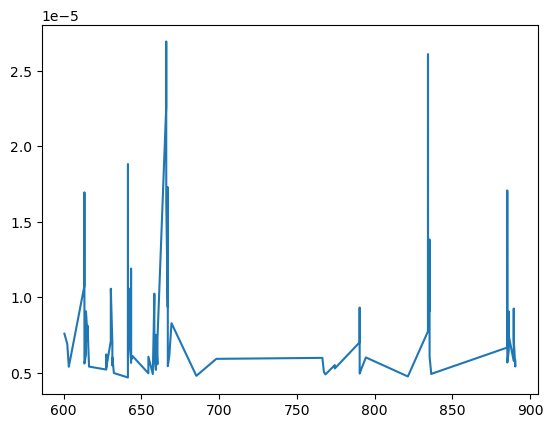

In [13]:
tic = tics["2_porous_nNs-r"][mzs_filter]
#tic = tics["2_tissue_section-s"][mzs_filter]
top_idx = tic.argsort()[-100:][::-1]
top_idx = sorted(top_idx)

plt.plot(mzs_filtered[top_idx], tic[top_idx])
plt.show()

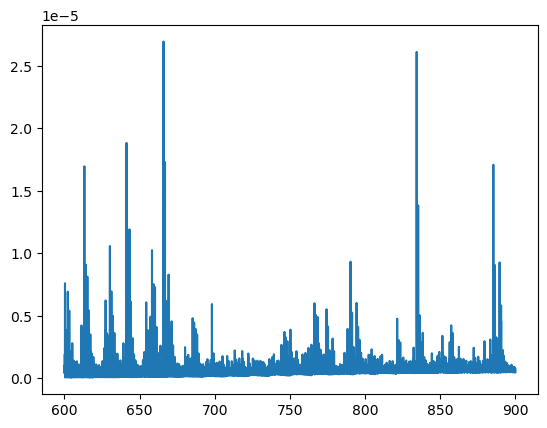

In [21]:
tic = tics["2_porous_nNs-r"][mzs_filter]
#tic = tics["2_tissue_section-s"][mzs_filter]

plt.plot(mzs_filtered, tic)
plt.show()

In [22]:
885.5498 + 0.025

885.5748

In [14]:
mzs_filtered[top_idx]

array([600.40625, 602.25625, 603.25625, 613.26875, 613.28125, 613.29375,
       613.30625, 613.31875, 614.26875, 614.28125, 614.29375, 615.26875,
       615.28125, 615.29375, 616.26875, 627.40625, 627.41875, 627.43125,
       630.25625, 630.26875, 630.28125, 631.26875, 631.28125, 631.29375,
       632.25625, 641.28125, 641.29375, 641.30625, 641.31875, 641.33125,
       642.29375, 642.30625, 642.31875, 643.29375, 643.30625, 643.31875,
       644.29375, 654.44375, 654.45625, 657.29375, 658.28125, 658.29375,
       658.30625, 658.31875, 659.29375, 659.30625, 660.28125, 660.29375,
       660.30625, 665.91875, 665.93125, 665.94375, 665.95625, 666.91875,
       666.93125, 666.94375, 666.95625, 667.94375, 669.33125, 685.31875,
       698.15625, 766.39375, 767.40625, 768.39375, 774.39375, 774.40625,
       774.41875, 790.36875, 790.38125, 790.39375, 790.40625, 791.39375,
       791.40625, 794.39375, 821.40625, 834.34375, 834.35625, 834.36875,
       834.38125, 834.39375, 835.35625, 835.36875, 

In [ ]:
mzs_filtered[tics["2_porous_nNs-r"][mzs_filter].argsort()[-200:][::-1]]

In [ ]:
MASS_RESOLUTION = 2

# 766.5
background_peaks = [602.41875]

gives_oposite = [
    666.05, 613.45, 631.45, 641.45, 669.45, 667.05, 611.45, 633.45, 659.45,
    658.45, 659.35, 682.55
]
not_good_in_2 = [
    791.55, 770.55, 774.55, 786.55, 789.55, 748.55, 768.55, 769.55, 822.65,
    810.55, 797.55, 796.55, 795.55, 834.65, 601.35
]
shit = [767.65, 890.75, 889.75, 823.65]
a = [
    774.55, 821.55, 795.55, 790.55, 889.65, 885.55, 823.55, 775.55, 788.55,
    668.05, 794.55, 835.55, 822.55, 890.65, 796.55, 768.55, 643.45, 766.55,
    791.55, 767.55, 642.45, 886.55, 889.75, 617.35, 629.35, 750.55, 746.55
]

[
    666.05625, 667.06875, 666.06875, 666.08125, 641.43125, 613.40625, 613.41875,
    615.41875, 630.40625, 658.44375, 630.41875, 658.43125
]

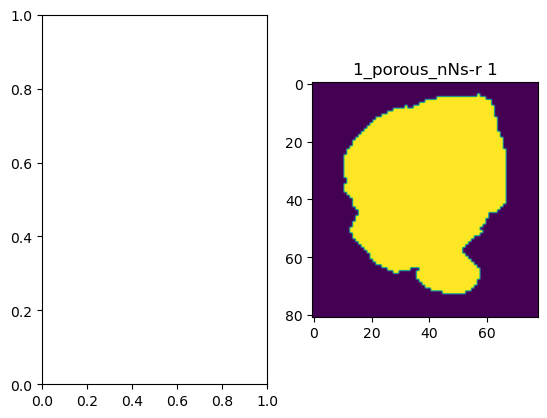

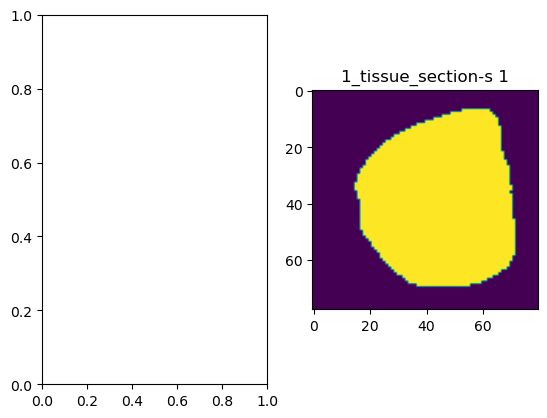

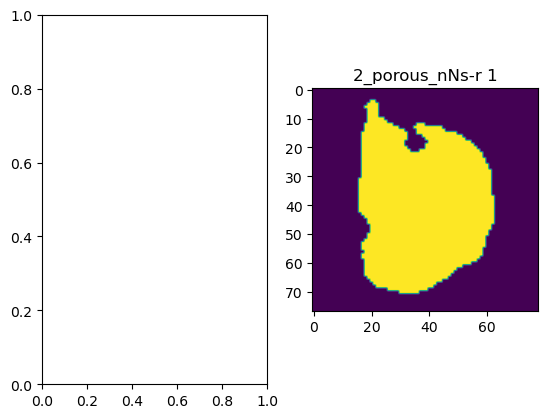

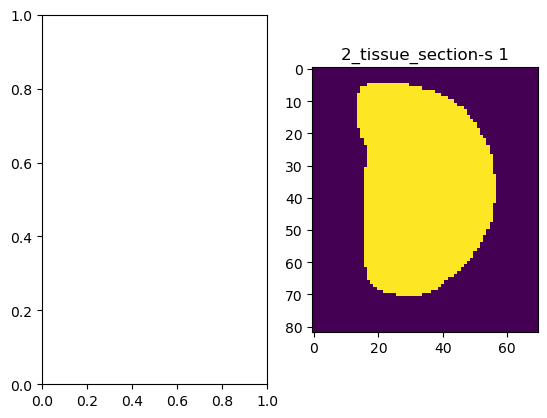

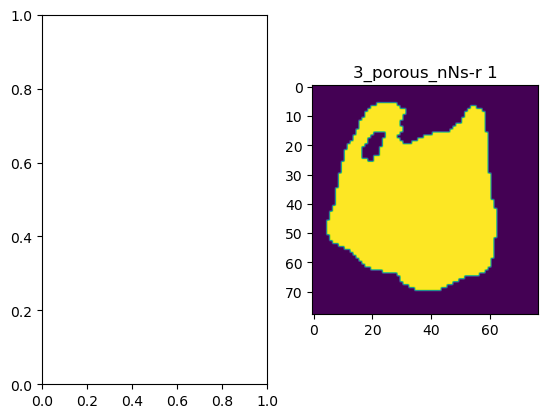

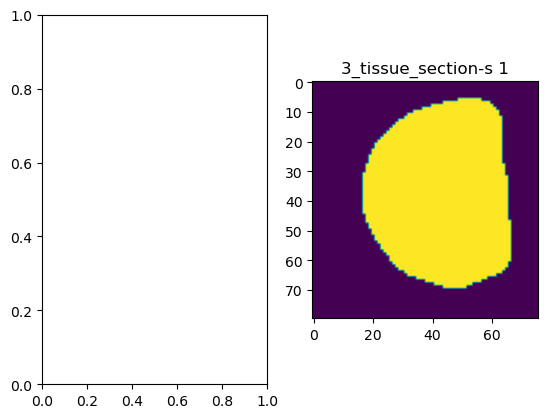

In [40]:
import numpy as np
from processing import MeanSegmentation

[682.6, 889.5, 860.5]
#representative_peaks = [794.55, 834.5, 886.6, 889.5, 860.5]
representative_peaks = mzs_filtered[top_idx]

#  +- 0.3
# 889.55

for peak in [1]:

  mass_resolution = 0.25

  for folder in PROCESSED_DATA.iterdir():
    with ImzMLParser(folder.joinpath("common_representation.imzML")) as p:
      #if '2' in folder.stem:
      if 'porous_nNs-r' in folder.stem or '-s' in folder.stem:
        # Get full msi
        mzs, img = read_msi(p)
        #
        #representative_peak_img = img[:,:, (mzs >= representative_peaks[0] - MASS_RESOLUTION) & (mzs <= representative_peaks[0] + MASS_RESOLUTION)]
        # Segment image
        segment_img = MeanSegmentation(
            mzs, [794.55, 834.55, 886.66, 885.5498, 860.55], mass_resolution
        ).segment(img)

        fig, (ax1, ax2) = plt.subplots(1, 2)
        #ax1.imshow(representative_peak_img, vmax=np.percentile(representative_peak_img,95))
        ax2.imshow(segment_img)
        plt.title(folder.stem + " " + str(peak))
        plt.show()

In [10]:
folder

PosixPath('../data/CHIP_TYPES_NEW/processed/2_tissue_section-s')

In [ ]:
from skimage.morphology import disk

disk(10)

In [ ]:
for folder in PROCESSED_DATA.iterdir():
  seg_path = folder / "segmentation.npy"
  seg_img = np.load(seg_path)
  plt.imshow(seg_img)
  plt.title(folder.stem)
  plt.show()

In [ ]:
!python liver_data_analysis.py

In [ ]:
!python chip_types_data_analysis.py

In [ ]:
!python main.py